# Time Series and Forecasting 
A time series analysis of the emeregency services call data in Jakarta. Based on real data supplied by the Indonsian government.
# Contents

1. Cleaning The Data


2. Call Data Analysis
        2.1. Administrative City/ Municipality
        2.2. Hour of The Day
        2.3. Day of The Week
        
3. Time Series Analysis
        3.1. Splitting The Data
        3.2. Decomposition Plot
        3.3. Autocorrelation Function (ACF)
        3.4. Partial Autocorrelation Function (PACF)

4. Forecast Models
        4.1. Baseline Naive2 Forecast
        4.2. Holt Winters
        4.3. Multiple Linear Regression
                4.3.1. Testing The Residuals (Multiple Linear Regression)
                4.3.2. Forecast and Testing (Multiple Linear Regression)
        4.4. ARIMA
                4.4.1. Testing The Residuals (ARIMA)
                4.4.2. Forecast and Testing (ARIMA)
                
5. Summary and Conclusions
        4.1. Testing The Residuals (Forecasst Model)

In [34]:
# Packages to Install
install.packages("tidyverse")
install.packages('MASS')
install.packages('forecast')
install.packages('xts')
install.packages("extrafont")
install.packages("timeSeries")
install.packages("tseries")
install.packages("lmtest")
install.packages("TSstudio")

# Import Libraries
library(tidyverse)
library(readxl) 
library(MASS)
library(forecast)
library(ggplot2)
library(xts)
library(extrafont)
library(timeSeries)
library(tseries)
library(lmtest)
library(TSstudio)
library(MASS)
library(caret)
library(nlme)
library(extrafont)


# Import the data
df <- read_excel('EmergencyCallData.xlsx')

# 1. Cleaning and Preprocessing
Data has been cleaned after previously exploring and analysing the dataset. This below section has been designed to automate cleaning and preprocessing.

In [35]:
###################################################################
# SEGMENT DATAFRAME ###############################################
###################################################################

# Get all etries with the Name 'JAK' in them called the Jakarta set
df_Jak <- df[grepl("JAK", df[["City Municipality"]]),]

# Get all the remainng entries called the remaininig set
df1 <- anti_join(df, df_Jak, by="City Municipality")



###################################################################
# JAKARTA SET CLEAN ###############################################
###################################################################
## Get All Entries for PUSAT with 'PUS'####
df_PUS <- df_Jak[grepl("PUS", df_Jak[["City Municipality"]]),]
df_Jak <- anti_join(df_Jak, df_PUS, by="City Municipality")
df_PUS[['City Municipality']] <- 'PUSAT'

## Get all entries for TIMUR with 'TIM'###
df_Tim <- df_Jak[grepl("TIM", df_Jak[["City Municipality"]]),]
df_Jak <- anti_join(df_Jak, df_Tim, by="City Municipality")
df_Tim[['City Municipality']] <- 'TIMUR'

## Get all entries for UTARA with 'UTA' ###
df_Uta <- df_Jak[grepl("UTA", df_Jak[["City Municipality"]]),]
df_Jak <- anti_join(df_Jak, df_Uta, by="City Municipality")
df_Uta[['City Municipality']] <- 'UTARA'

## Get All Entries for BARAT with 'BAR' ###
df_Bar <- df_Jak[grepl("BAR", df_Jak[["City Municipality"]]),]
df_Jak <- anti_join(df_Jak, df_Bar, by="City Municipality")
df_Bar[['City Municipality']] <- 'BARAT'

## Get all entries for SELATAN with 'SEL' ###
df_Sel <- df_Jak[grepl("SEL", df_Jak[["City Municipality"]]),]
df_Jak <- anti_join(df_Jak, df_Sel, by="City Municipality")
df_Sel[['City Municipality']] <- 'SELATAN'



###################################################################
# REMAINING SET CLEAN #############################################
###################################################################

# Search the raming entires for Jakarta set and manuallly search for the relevant hospital
search_timur <- c(
    'JAKARTA TMUR','JAKARTA T]','JAKARTA T',
    'JAKARTA KELUR','KRAMAT JATI','JL SERUNI',
    'RS PUSDIKKES'
)
search_barat <- c(
    'BARAT','BEKASI','PEJATEN','KALIMANTAN',
    'RS PURI INDAH','RS AL-KAMAL','RSUK TAMAN SARI'
)
search_pusat <- c('PUSAT')
search_selatan <- c(
    'JAKARTA S','SELATAN','TANGASTOENTERITISRANG',
    'TANGERANG','KOTA TANGASTOENTERITISRANG','RS TEBET',
    'RS MAYAPADA LEBAK','JL SUBUR DALAM','JL WIJAYA',
    'KUNINGAN','RS PETUKANGAN','RSUD MAMPANG'
)
search_utara <- c('UTARA','RSUD TUGU KOJA')

#  Add correct entries to TIMUR
df_t_Jak <- dplyr::filter(df_Jak, grepl(paste(search_timur, collapse="|"), 
                                        df_Jak[["City Municipality"]]))
df_t_df1 <- dplyr::filter(df1, grepl(paste(search_timur, collapse="|"), 
                                     df1[["City Municipality"]]))
df_Jak <- anti_join(df_Jak, df_t_Jak, by="City Municipality")
df1 <- anti_join(df1, df_t_df1, by="City Municipality")
df_t <- rbind(df_t_Jak, df_t_df1)
df_t[['City Municipality']] <- 'TIMUR'
df_Tim <- rbind(df_Tim, df_t)

#  Add correct entries to SELATAN
df_s_Jak <- dplyr::filter(df_Jak, grepl(paste(search_selatan, collapse="|"), 
                                        df_Jak[["City Municipality"]]))
df_s_df1 <- dplyr::filter(df1, grepl(paste(search_selatan, collapse="|"), 
                                     df1[["City Municipality"]]))
df_Jak <- anti_join(df_Jak, df_s_Jak, by="City Municipality")
df1 <- anti_join(df1, df_s_df1, by="City Municipality")
df_s <- rbind(df_s_Jak, df_s_df1)
df_s[['City Municipality']] <- 'SELATAN'
df_Sel <- rbind(df_Sel, df_s)

#  Add correct entries to BARAT
df_b_Jak <- dplyr::filter(df_Jak, grepl(paste(search_barat, collapse="|"), 
                                        df_Jak[["City Municipality"]]))
df_b_df1 <- dplyr::filter(df1, grepl(paste(search_barat, collapse="|"), 
                                     df1[["City Municipality"]]))
df_Jak <- anti_join(df_Jak, df_b_Jak, by="City Municipality")
df1 <- anti_join(df1, df_b_df1, by="City Municipality")
df_b <- rbind(df_b_Jak, df_b_df1)
df_b[['City Municipality']] <- 'BARAT'
df_Bar <- rbind(df_Bar, df_b)

#  Add correct entries to PUSAT
df_p_Jak <- dplyr::filter(df_Jak, grepl(paste(search_pusat, collapse="|"), 
                                        df_Jak[["City Municipality"]]))
df_p_df1 <- dplyr::filter(df1, grepl(paste(search_pusat, collapse="|"), 
                                     df1[["City Municipality"]]))
df_Jak <- anti_join(df_Jak, df_p_Jak, by="City Municipality")
df1 <- anti_join(df1, df_p_df1, by="City Municipality")
df_p <- rbind(df_p_Jak, df_p_df1)
df_p[['City Municipality']] <- 'PUSAT'
df_PUS <- rbind(df_PUS, df_p)

#  Add correct entries to UTARA
df_u_Jak <- dplyr::filter(df_Jak, grepl(paste(search_utara, collapse="|"), 
                                        df_Jak[["City Municipality"]]))
df_u_df1 <- dplyr::filter(df1, grepl(paste(search_utara, collapse="|"), 
                                     df1[["City Municipality"]]))
df_Jak <- anti_join(df_Jak, df_u_Jak, by="City Municipality")
df1 <- anti_join(df1, df_u_df1, by="City Municipality")
df_u <- rbind(df_u_Jak, df_u_df1)
df_u[['City Municipality']] <- 'UTARA'
df_Uta <- rbind(df_Uta, df_u)

# Mark the remaining entries which could not be identified
df_Jak[['City Municipality']] <- 'Jakarta'
df1[['City Municipality']] <- 'Unknown'

###################################################################
# COMBINING CLEANED ###############################################
###################################################################
df_clean <- rbind(df_Tim, df_Bar, df_PUS, df_Sel, df_Uta)
df_others <- rbind(df_Jak, df1)
df_all <- rbind(df_clean, df_others)


###################################################################
# ADDITIONAL COLUMNS df_clean #####################################
###################################################################

# Create Dataframe to analyse Jakarta administrative cities
df_clean$Municipality <- df_clean[['City Municipality']]
df_clean[['City Municipality']] <- NULL
df_clean$DayOfWeekName <- weekdays(df_clean$Call)
wkday <-list(
    Monday = 1, Tuesday=2, Wednesday=3,Thursday=4,
    Friday=5,Saturday=6,Sunday=7
)
df_clean <- df_clean %>% 
mutate(
    DayOfWeekNum = wkday[DayOfWeekName],
    Date = as.Date(Call),
    Hour = format(as.POSIXlt(Call),format = '%H'),
    Week = strftime(Date, format = "%V")
) %>% 
arrange(
    Call
) %>% 
slice(
    3:n()
)



###################################################################
# ADDITIONAL COLUMNS df_all #######################################
###################################################################

# Create dataframe to analyse all entries for model creation  
df_all$Municipality <- df_all[['City Municipality']]
df_all[['City Municipality']] <- NULL
df_all$DayOfWeekName <- weekdays(df_all$Call)
df_all <- df_all %>% 
mutate(
    DayOfWeekNum = wkday[DayOfWeekName],
    Date = as.Date(Call),
    Hour = format(as.POSIXlt(Call),format = '%H'),
    Week = strftime(Date, format = "%V")
) %>% 
arrange(
    Call
) %>% 
slice(
    3:n()
)

###################################################################
# NEW Dataframes ##################################################
###################################################################

# Group all entries by indivdiaul Date
df_date <- group_by(df_all, Date) %>% summarise(
    NumberOfCalls = n(),
    DayOfWeekName = unique(DayOfWeekName)  
)

# Group Entries by hour of call
df_hour <- group_by(df_clean, Hour) %>% summarise(
    NumberOfCalls = n()
)

# Group entries by muniscipality and hour
df_district <- group_by(df_clean, Municipality, Hour) %>% summarise(
    NumberOfCalls = n()
)

# Group entriese by Day of the week, hour, and Date
df_dayhour <- group_by(df_clean, DayOfWeekName, Hour, Date) %>% summarise(
    Calls = n(),
) %>% 
arrange(
    Date
)

# Group entries by week number and day of the week
df_week <- group_by(df_all, Week, DayOfWeekName) %>% summarise(
    Calls = n()
)
df_week$DayOfWeekName<- factor(df_week$DayOfWeekName, 
                               levels = c(
                                   'Monday','Tuesday','Wednesday',
                                   'Thursday','Friday','Saturday','Sunday'
                               )
                              )

# Group Entries by Day of the Week
df_day <- group_by(df_week, DayOfWeekName) %>% summarise(
    NumberOfCalls = sum(Calls),
    Ave = round(mean(Calls), 2),
    Std = round(sd(Calls), 2)
)
day_order <- c(
    'Monday','Tuesday','Wednesday','Thursday',
    'Friday','Saturday','Sunday'
)
df_day <- df_day[match(day_order, df_day$DayOfWeekName),]

`summarise()` has grouped output by 'Municipality'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'DayOfWeekName', 'Hour'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Week'. You can override using the `.groups` argument.



# 2. Call Data Analysis
Analyse the data to get a feel for the dataset.
## 2.1. Administrative City/ Municipality
Exploring the data per administrative city/municipality.

In [36]:
# Generatae the percentage of calls per district of Jakarta
x <- group_by(df_clean, Municipality) %>% summarise(
    NumberOfCalls = n(),
    Percentge = round(n()/22324,3)
)

print("Number of Undistiguishable Entries: ")
print(nrow(df_others)/nrow(df_all)*100)
x

[1] "Number of Undistiguishable Entries: "
[1] 0.9495075


Municipality,NumberOfCalls,Percentge
<chr>,<int>,<dbl>
BARAT,5290,0.237
PUSAT,5683,0.255
SELATAN,3801,0.170
TIMUR,4558,0.204
UTARA,2992,0.134


## 2.2. Hour of The Day
Exploring the data per hour of the day. 

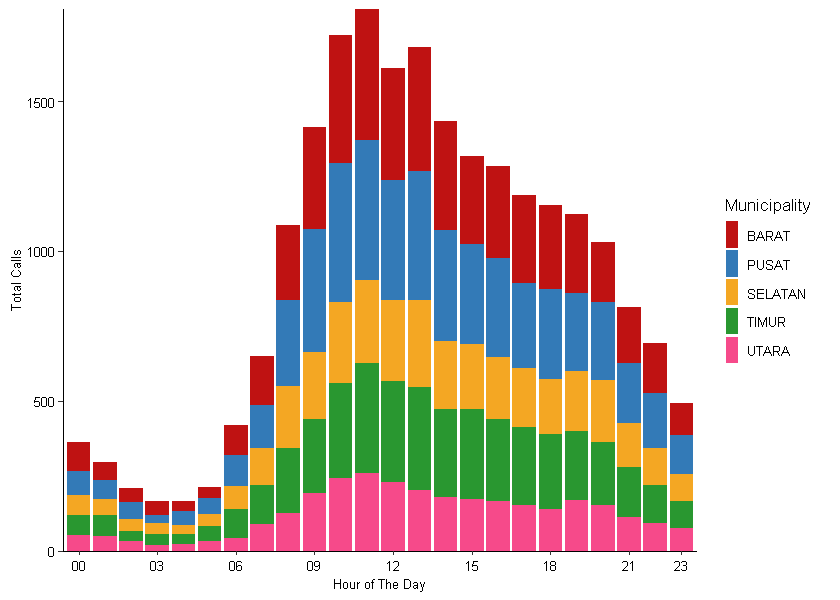

In [37]:
# loadfonts(device="win")  
options(repr.plot.width=7, repr.plot.height=5)      
hour <- ggplot() + geom_bar( data = df_clean, aes(x=Hour, fill=Municipality)) +
    theme_classic() + theme(
        axis.text.x= element_text(family= 'sans', colour='black', size=8),
        axis.title.x = element_text(family= 'sans', colour ='black', size=8), 
        axis.text.y = element_text(family= 'sans', colour ='black', size=8),
        axis.title.y = element_text(family= 'sans', colour ='black', size =8 ),
        legend.title=element_text(family= 'sans', colour ='black', size = 10),
        legend.text=element_text(family= 'sans', colour ='black', size = 8),
        legend.key.width = unit(0.3,"cm")
    ) +
    scale_x_discrete(
        'Hour of The Day', 
        breaks=c('00','03','06','09',12,15,18,21,23)
    ) + 
    scale_y_discrete('Total Calls', limits=c(0,500,1000,1500))+
    scale_fill_manual(values=c('#BF1212',
                               '#337ab7', 
                               '#f4a723',
                               '#299730',
                               '#f64a8a'))  
ggsave("Hours.png",
       plot = hour, 
       device = "png", 
       dpi=150, 
       width=8.5, 
       height=5, 
       units = "cm")
hour

## 2.3.  Day of The Week
Exploring the data per week of the year.

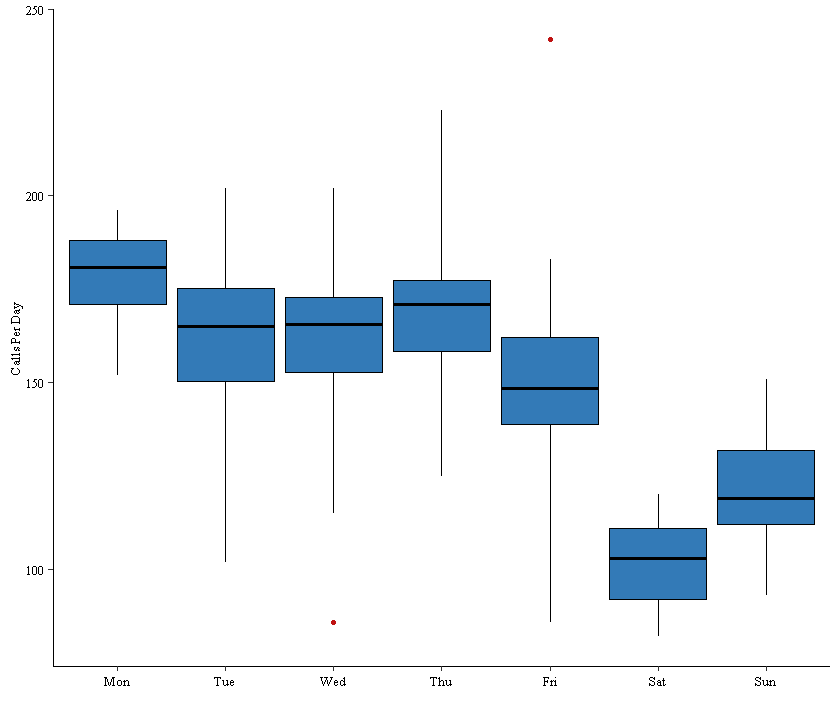

In [38]:
# Genereate Plot to identify calls per day of the week
cols <- 'black'
options(repr.plot.width=7, repr.plot.height=6)
day <- ggplot(df_week, aes(DayOfWeekName, Calls)) + 
        geom_boxplot(fill='#337ab7', color=cols, outlier.colour='#BF1212', 
                     outlier.shape=16, outlier.size=1,width=0.9, coef=3
                    ) +
        theme_classic() + theme(
        axis.text.x= element_text(family= 'Times New Roman', colour=cols, size=8),
        axis.text.y = element_text(family= 'Times New Roman', colour =cols, size=8),
        axis.title.y = element_text(family= 'Times New Roman', colour =cols, size = 8)
        ) + 
        labs(x = "", y = "Calls Per Day") + 
        scale_x_discrete(labels=(c('Mon','Tue','Wed','Thu','Fri','Sat','Sun')))
ggsave("BoxPlot.png",
       plot = day, 
       device = "png", 
       dpi=150, 
       width=6, 
       height=5.2, 
       units = "cm")
day

In [40]:
###################################################################
# QUANTITATIVE INFORMATION ########################################
###################################################################

# Day of Week Inforation calculataion
df_week[df_week$Week != 22, ] %>% group_by(DayOfWeekName) %>%
summarise(
    Count = n(),
    CallTotal = sum(Calls),
    Proportion = round(CallTotal/(3755+3531+3537+3710+3334+2151+2520)*100,3),
    Average = round(mean(Calls)),
    Median = round(median(Calls)),
    Std.Dev = round(sd(Calls)),
    Minimum = min(Calls),
    OutlierLower = quantile(Calls)[2] - ((quantile(Calls)[4]- quantile(Calls)[2]) * 3),
    LowerObs = length(which(Calls<OutlierLower)),
    Maximum = max(Calls),
    OutlierUpper = ((quantile(Calls)[4]- quantile(Calls)[2]) * 3) + quantile(Calls)[4],
    UpperObs = length(which(Calls>OutlierUpper))
)

# The first Monday is not counted since it was 31/12/2018, so Week 22 for monday is counted as Week 21
df_week[df_week$Week == 22, ]

# Working out the new 'Proportions' with Monday count updated to 21
mon = 3577 + 178
tue = 3329
wed = 3379
thu = 3579
fri = 3205
sat = 2151
sun = 2520
tot = sum(c(mon,tue,wed,thu,fri,sat,sun))


day <- sun # CHANGE ME
print('New Proportion:')
print(day/tot)

DayOfWeekName,Count,CallTotal,Proportion,Average,Median,Std.Dev,Minimum,OutlierLower,LowerObs,Maximum,OutlierUpper,UpperObs
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>
Monday,20,3577,15.871,179,182,12,152,119,0,196,239.75,0
Tuesday,21,3329,14.771,159,165,25,102,77,0,200,245.00,0
Wednesday,21,3379,14.992,161,166,26,86,85,0,202,239.00,0
Thursday,21,3579,15.880,170,172,20,125,106,0,223,232.00,0
Friday,21,3205,14.220,153,149,29,86,75,0,242,229.00,1
Saturday,21,2151,9.544,102,103,11,82,35,0,120,168.00,0
Sunday,21,2520,11.181,120,119,15,93,52,0,151,192.00,0


Week,DayOfWeekName,Calls
<chr>,<fct>,<int>
22,Friday,129
22,Monday,178
22,Thursday,131
22,Tuesday,202
22,Wednesday,158


[1] "New Proportion:"
[1] 0.114974


# 3. Time Series Analysis
Creating and testing time series models based on the emergency call data.
## 3.1. Splitting the Data
Split the data into training and test sets for the models. Ensure that the dates are such that the models created can forecast in weeks and be accurately tested against the test data.

In [70]:
# Create Split number
split_percentage <- 0.7
split_num <- round(nrow(df_date) * split_percentage)
end_num <- nrow(df_date)

# Split the Dataset
train <- df_date[1:split_num,]
test <- df_date[(split_num+1):end_num,]

# Convert to Time series
all_ts <- ts(df_date$NumberOfCalls,start=c(2019,01), end=c(2019,151), frequency =7)
train_ts <- ts(train$NumberOfCalls,start=c(2019,01), end=c(2019,106), frequency =7)
test_ts <- ts(test$NumberOfCalls,start=c(2019,107), end=c(2019,151), frequency =7)

## 3.2. Decomposition Plot
Viewing the decomposition plot to get a visual idea as to what time series models may be applicable.

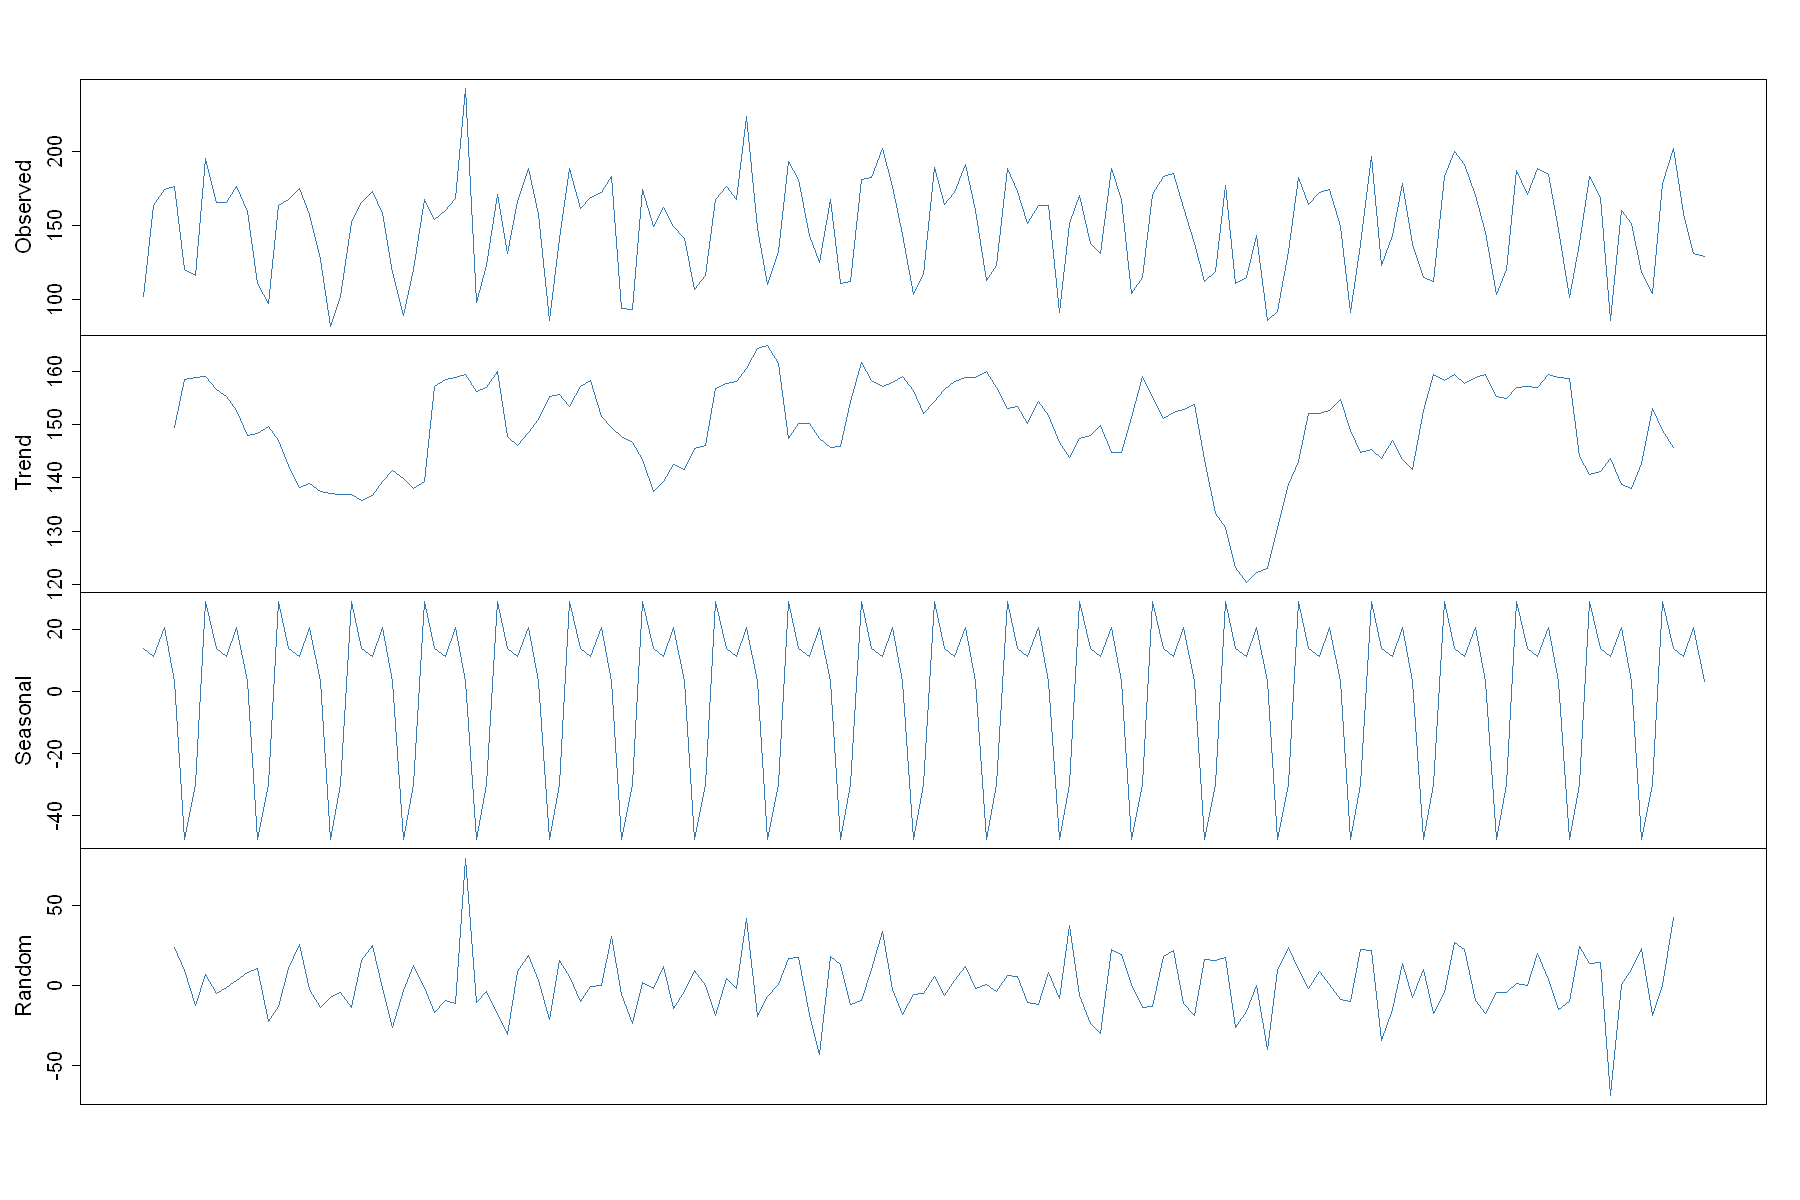

In [42]:
# Adjust Plot Size
options(repr.plot.width=15, repr.plot.height=10)

# Create Decomposition object
decom <- decompose(all_ts)

# Edit Plot Properties
my_plot.decomposed.ts = function(x) {
  xx <- x$x
  if (is.null(xx)) 
    xx <- with(x, if (type == "additive") 
      random + trend + seasonal
      else random * trend * seasonal)
            
      plot(cbind(Observed = xx, Trend = x$trend, Seasonal = x$seasonal, Random = x$random), 
       main= '', col='#337ab7', lwd=1, xaxt='n', xlab='')
}

# Plot the decomposition object
png(filename="Decomposition.png", width = 490, height = 400)
par(cex.lab=1.1, cex.axis=1.5, cex.main=1.5)
my_plot.decomposed.ts(decom)
dev.off()

## 3.3. Autocorrelation Function (ACF)
Test the conclusions drawn from the visual inspection of the decomposition plot.

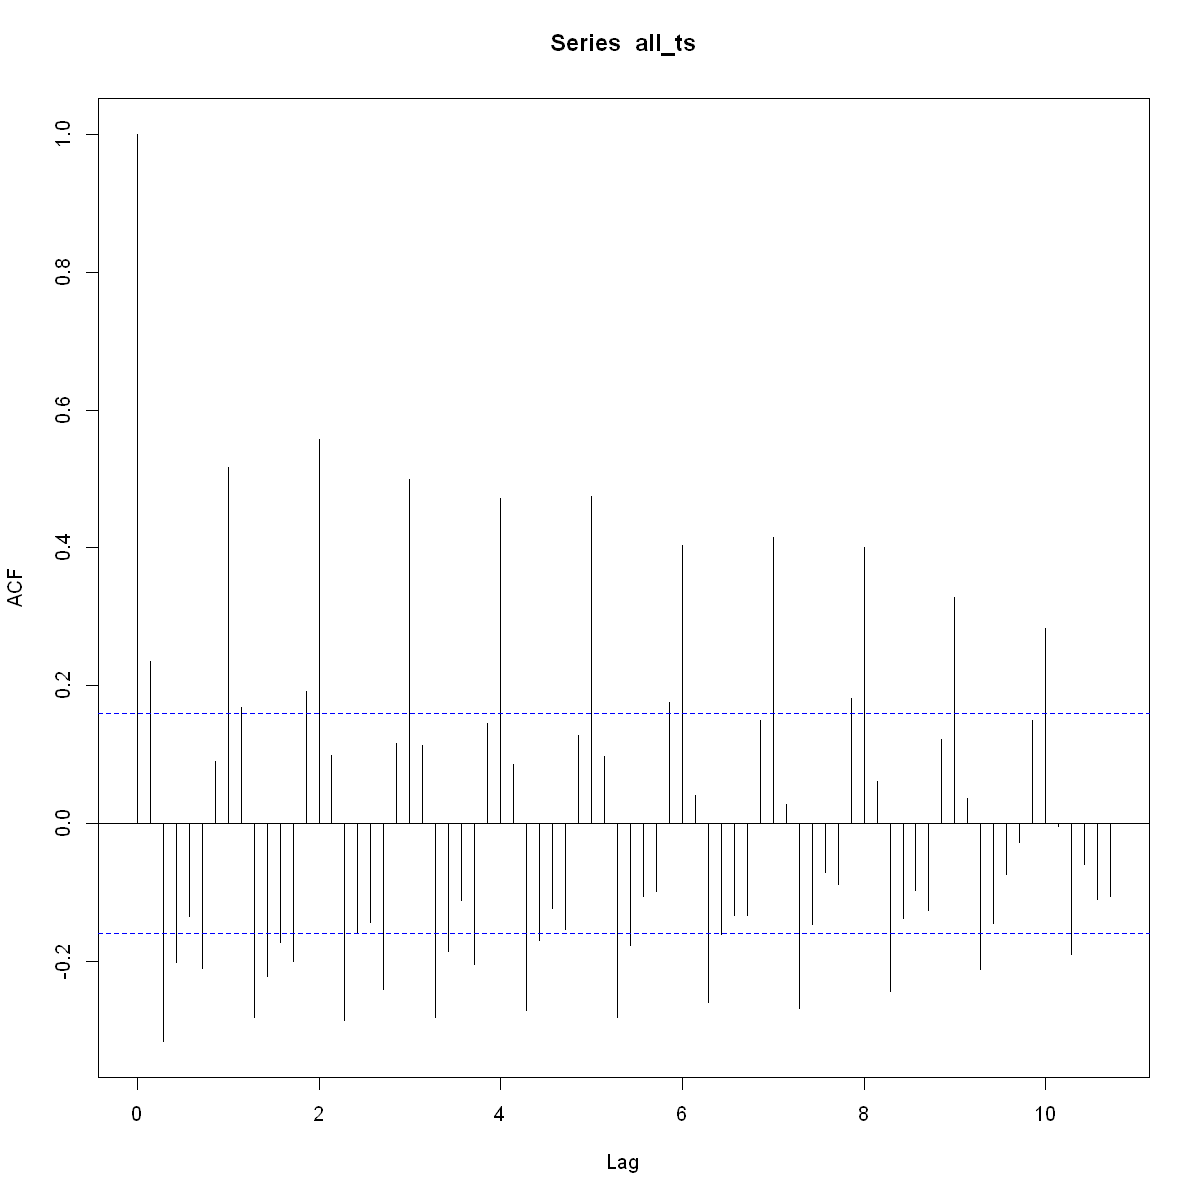

In [56]:
# Adjust Plot size
options(repr.plot.width=15, repr.plot.height=10, mar=c(1,2,0,0))

# Create ACF
x_acf <- acf(all_ts, 75, calc.ci=TRUE)

# Plot The Graph
png(filename="ACF.png", width = 200, height = 170)
par(cex.axis=1, mar=c(0,2,0,0), family="sans")
plot(x_acf, lwd=0.1, col = '#337ab7', main='', ylab='', ylim=c(-0.4,1), 
     xlab = '', frame.plot=FALSE, xaxt='n', ci.col='#BF1212')
abline(0,0, col = '#034EA2')
dev.off()

## 3.4. Partial Auto Correlation Function (PACF)
Test the conclusions drawn from the visual inspection of the decomposition plot.

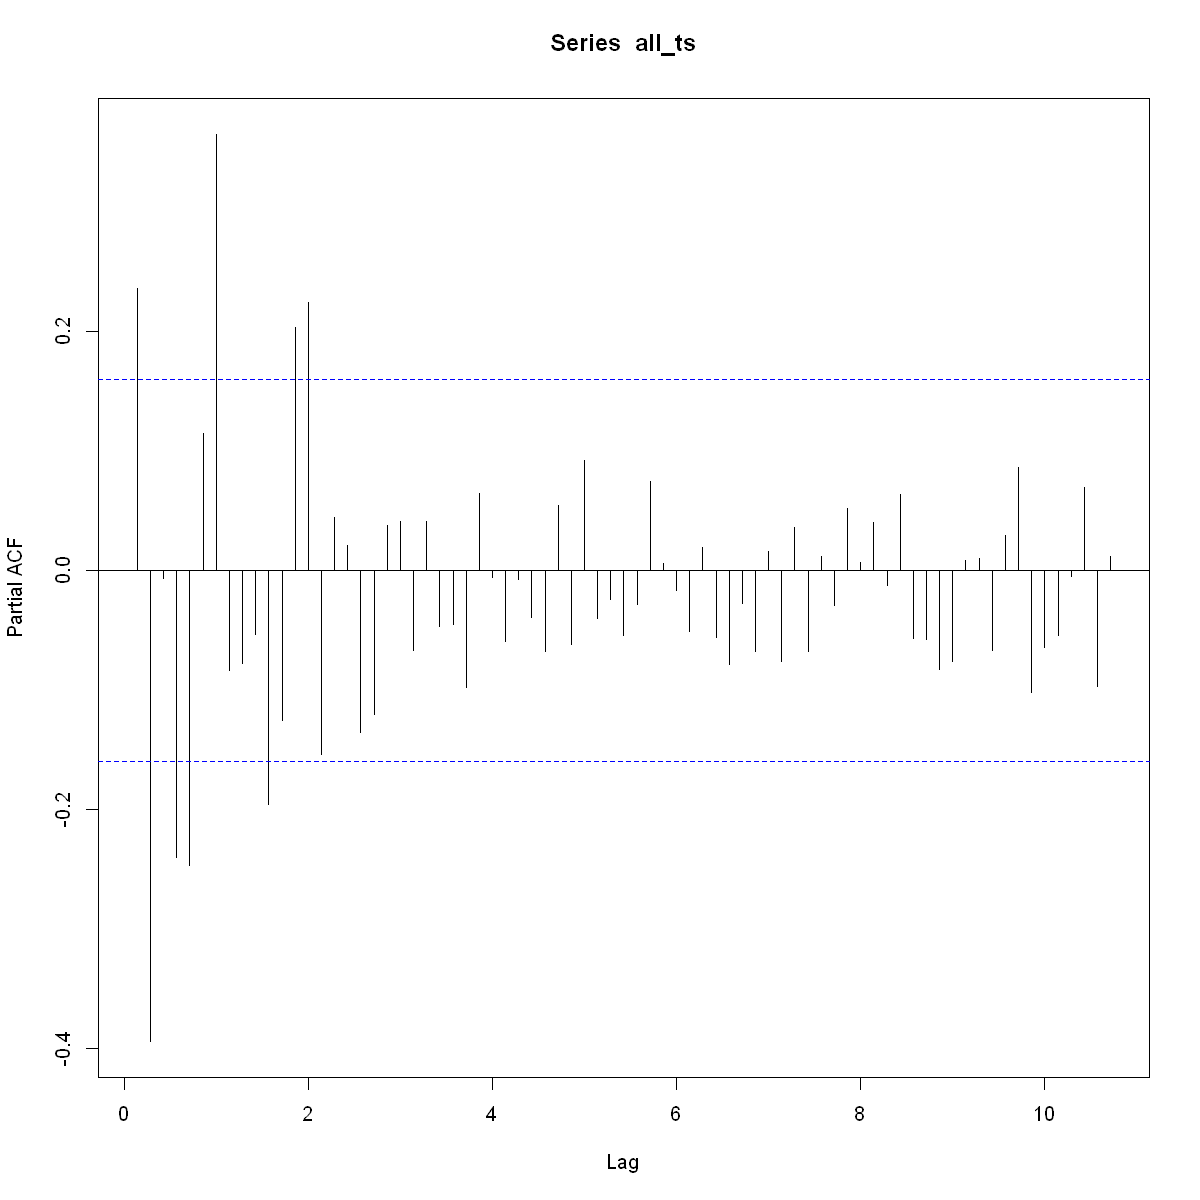

In [64]:
# Adjust Plot size
options(repr.plot.width=10, repr.plot.height=10)

# Create PACF
x_pacf <- pacf(all_ts, lag = 75, pl = TRUE)

# Plot the Graph
png(filename="PACF.png", width = 200, height = 170)
par(cex.axis=1, mar=c(0,2,0,0), family="sans")
plot(x_pacf, col = '#337ab7', lwd=0.7, main='', ylab='', xlab = '', 
     frame.plot = FALSE, xaxt='n', , ci.col='#BF1212', ylim=c(-0.4,1))
abline(0,0, col = '#034EA2')
while (!is.null(dev.list()))  dev.off()

# 4. Forecast Models
Create the time series models using the training dataset and the use the models developed to make predictions 
## 4.1. Baseline Naive Forecast 2
Create a baseline model and make forecast, using a Naive Forecast 2 model to account for seasonality. Using the error statistics as the baseline figures.

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.4242424,29.59115,20.48485,-2.061059,13.9320,1.000000,0.12633895,NA
Test set,2.8666667,33.92246,22.77778,-1.912164,16.8209,1.111933,-0.07246163,0.6317607


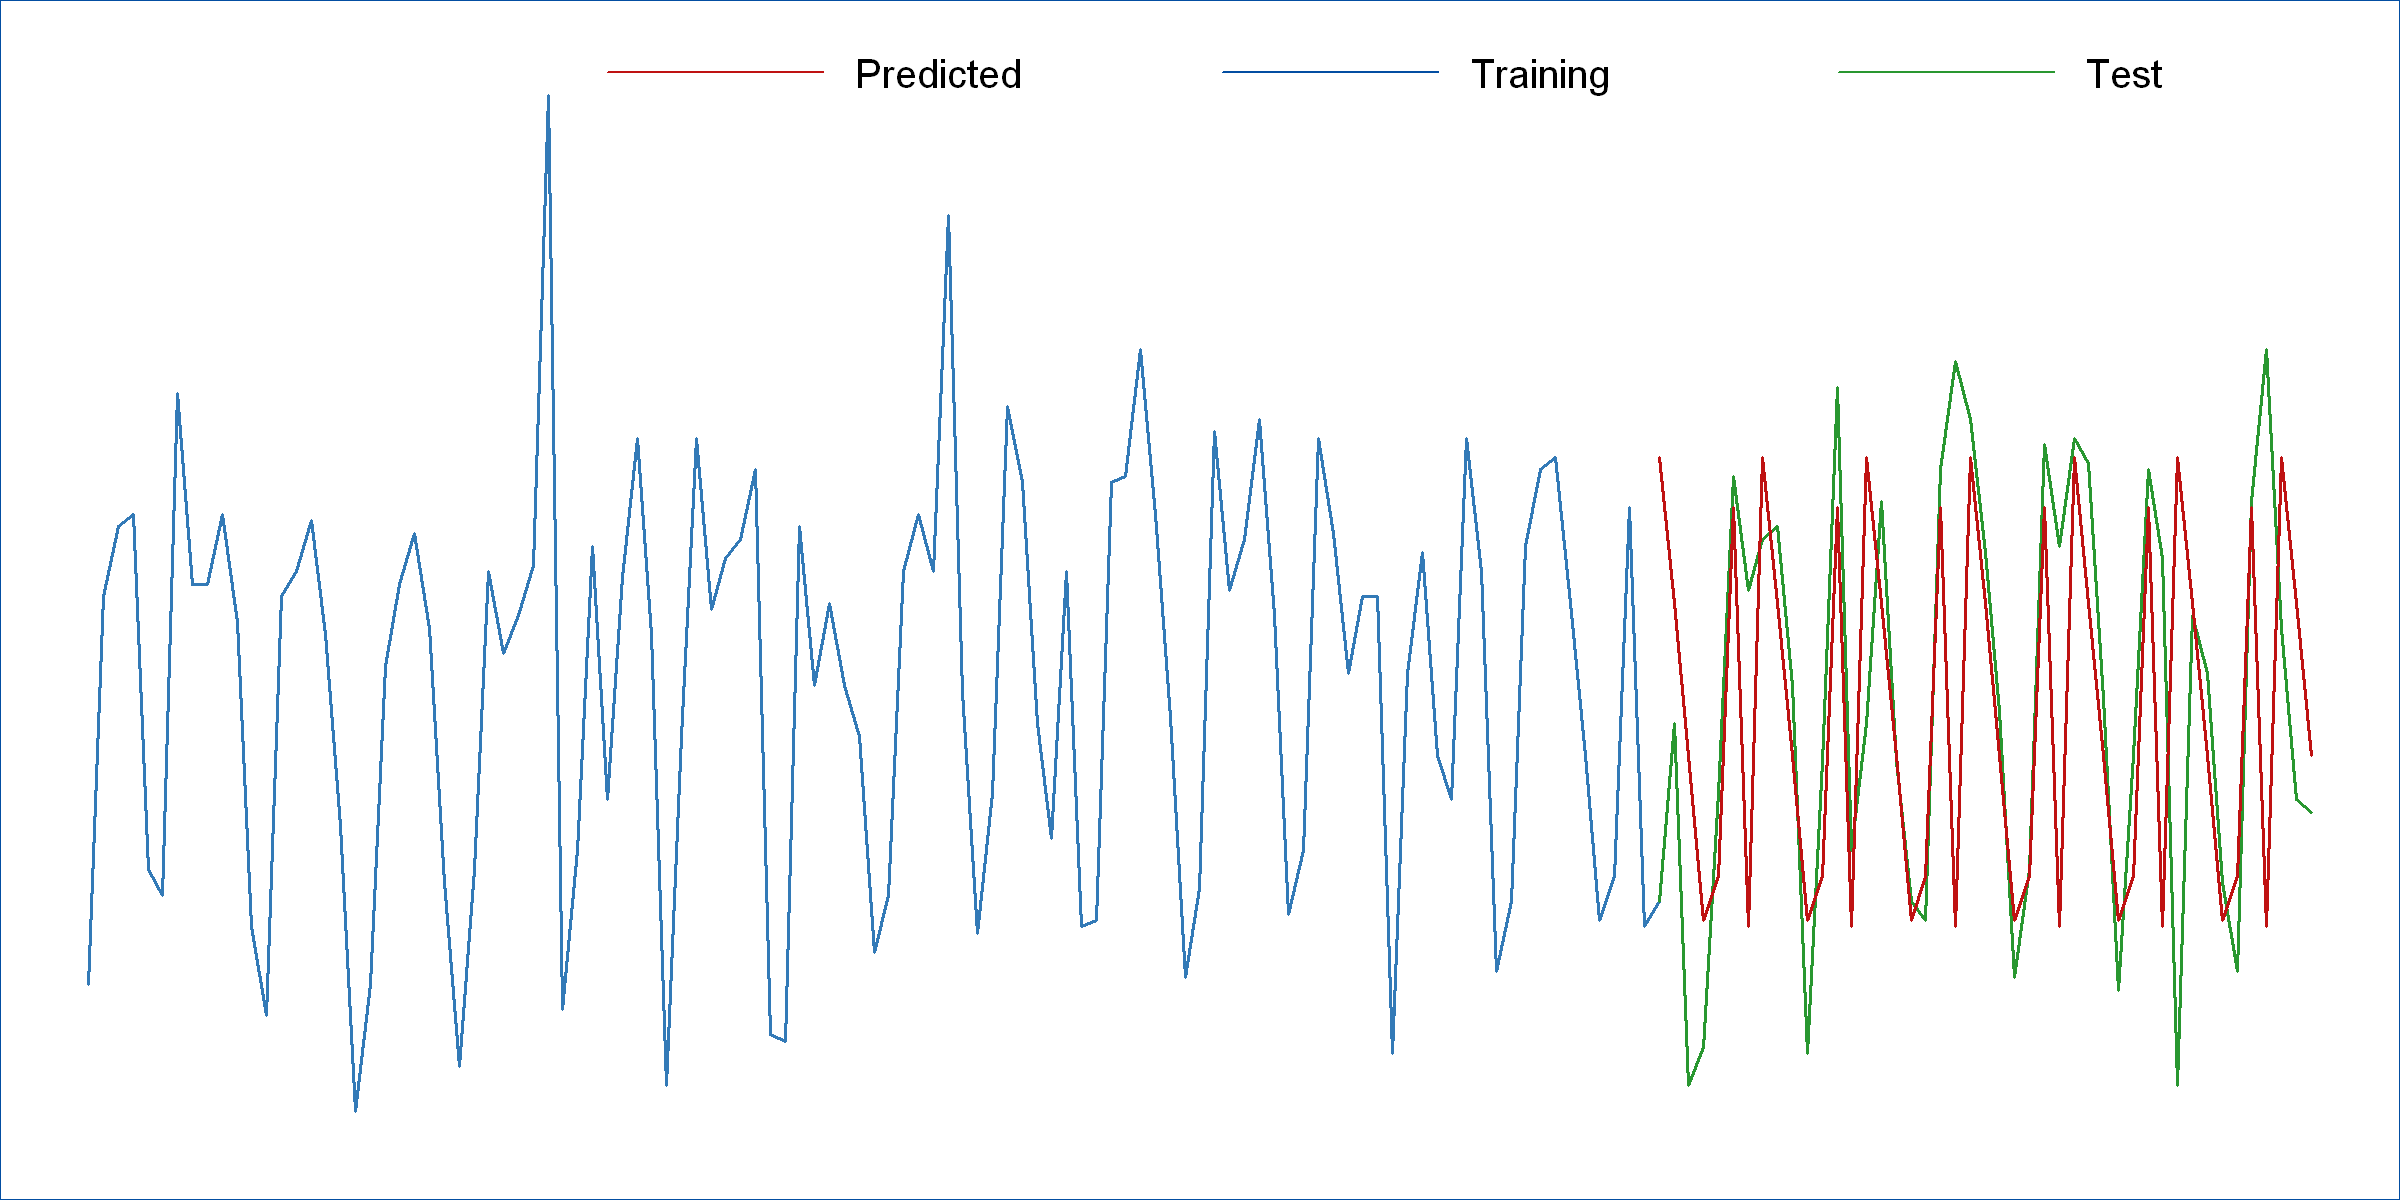

In [63]:
# Adjust Plot size
options(repr.plot.width=20, repr.plot.height=10)

# Create Model
nav_mod <- snaive(train_ts, level=c(80,90), h=length(test_ts))

# forecast The Test Data Length
nav_pred <- forecast(nav_mod, h=length(test_ts))

# Determine the Accuracy Statistics
nav_acc <- accuracy(nav_pred, x=test_ts) 
nav_acc

# Plot The Results
png(filename="Naive.png", width = 450, height = 100)
par(cex.lab=1, cex.axis=1, cex.main=1, mar=c(0,0,0,0), 
    mgp=c(0,0,0), family="sans")
plot(all_ts, col='#337ab7', lwd=3, ylab='', main='', ylim=c(75,250), 
     xlab='', fg='#034EA2')
lines(test_ts, col='#299730', lwd=3)
lines(nav_pred$mean, col='#BF1212', lwd=3)
legend( "topright", c("Predicted", "Training", "Test"), 
       col=c('#BF1212','#034EA2','#299730'), 
       pt.cex=, cex=2, lty=1, lwd=2, xjust = 1, text.width=2.5, bty='n', 
       seg.len=2, x.intersp=0.3, ncol=3) 
dev.off()

## 4.2. Holt Winters

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = train_ts)

Smoothing parameters:
 alpha: 0.110408
 beta : 0.01986048
 gamma: 0.07636076

Coefficients:
          [,1]
a  142.3810580
b   -0.2271542
s1  13.6719372
s2  22.6848900
s3  12.2640819
s4 -43.3934936
s5 -33.3336806
s6  30.5835608
s7   9.6632715

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,7.655392,26.42829,21.02439,2.498893,15.29713,0.2742689,0.560746


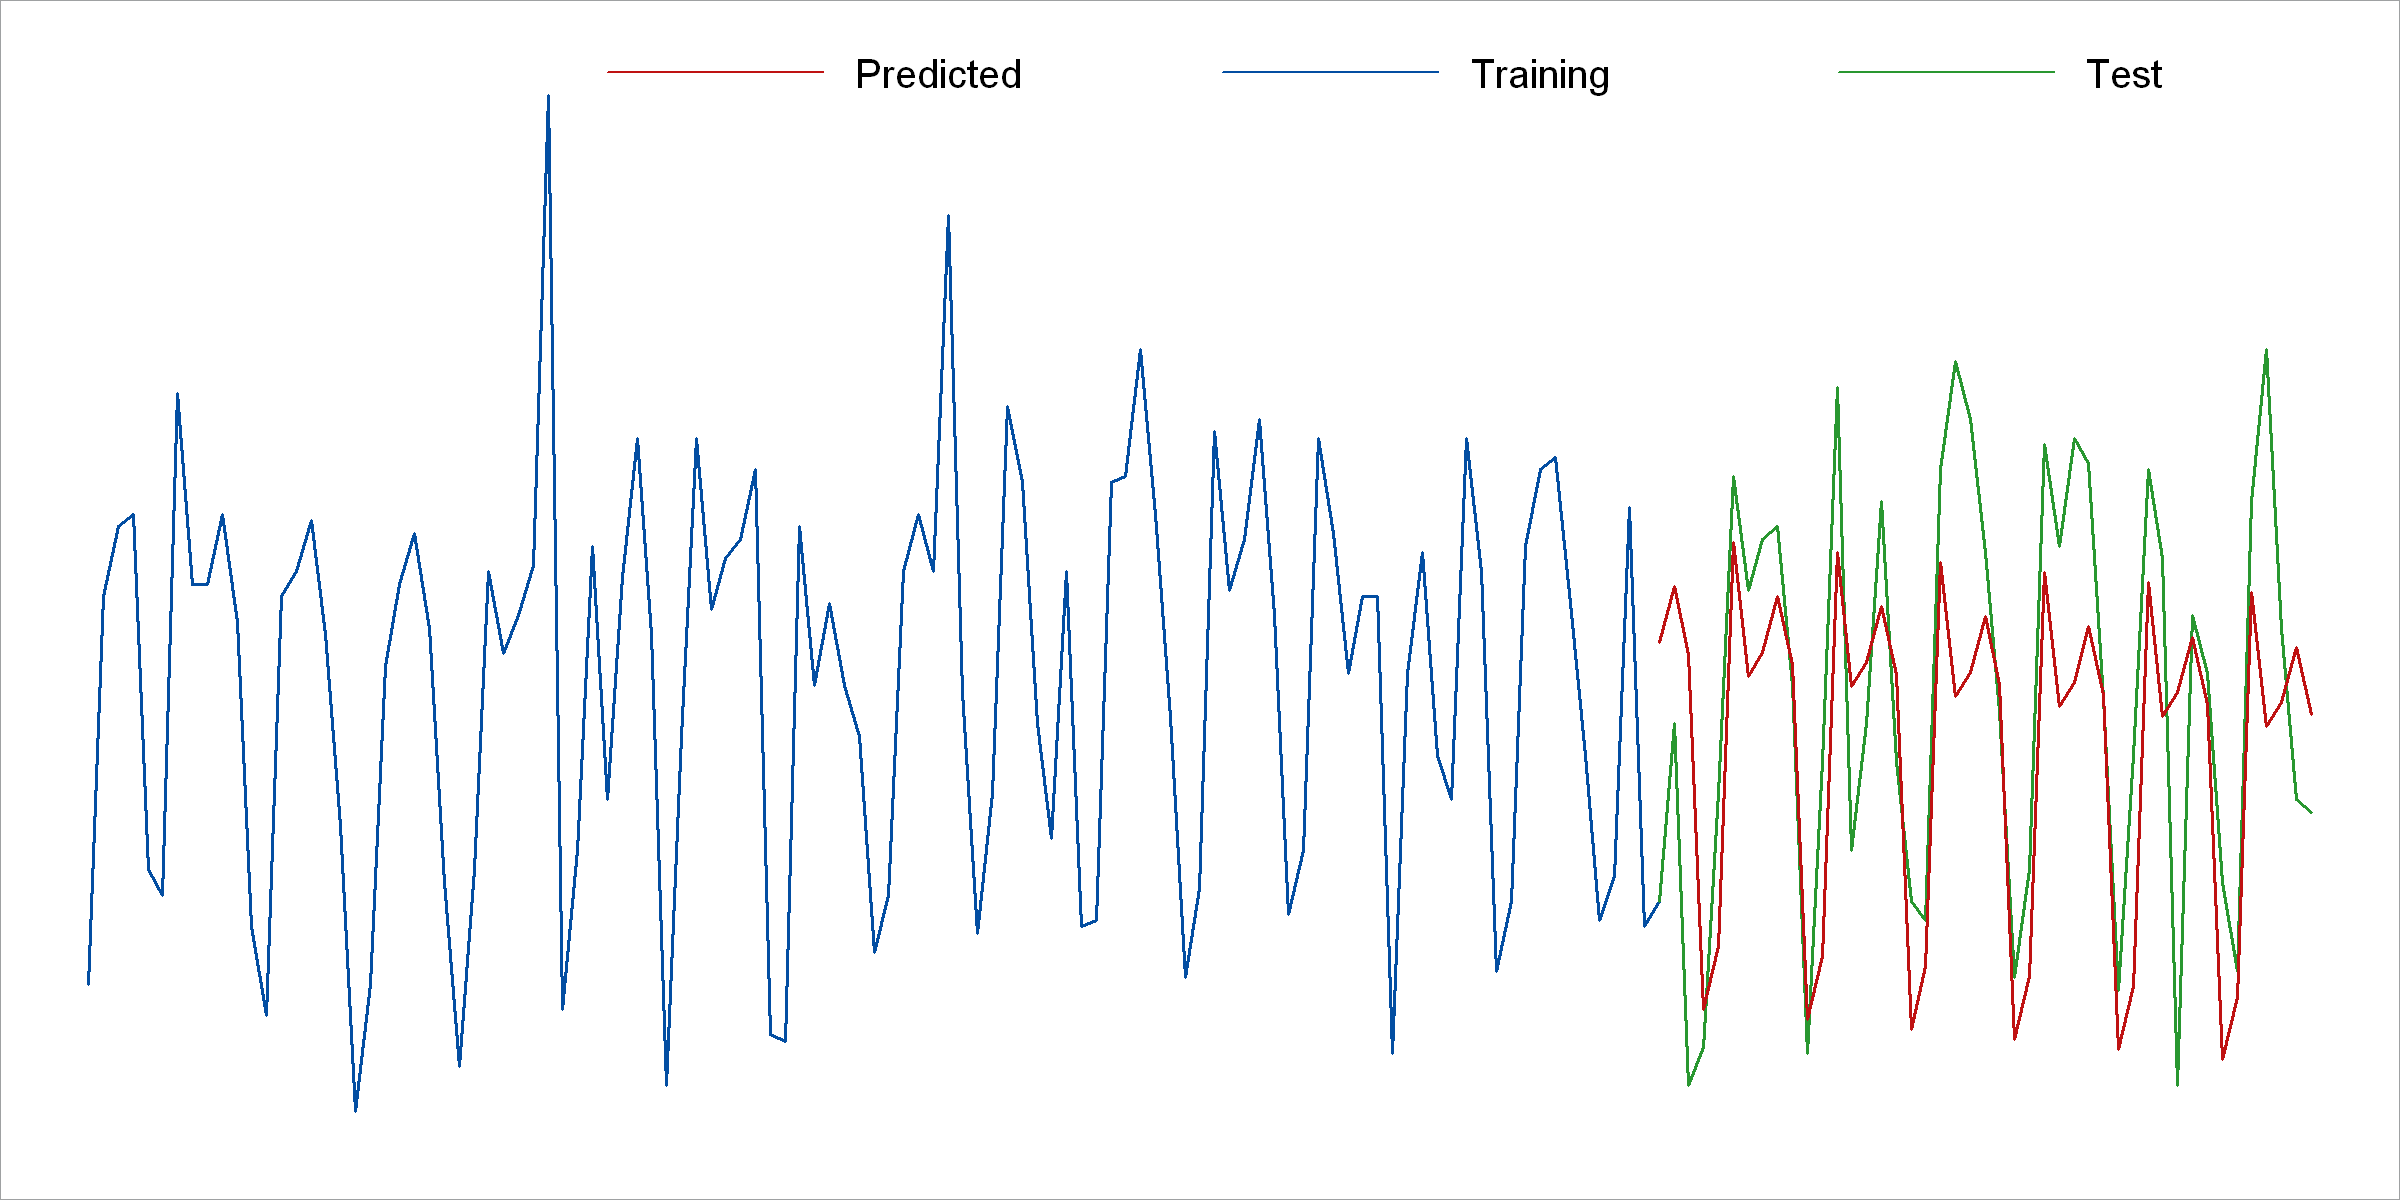

In [50]:
# Adjust Plot size
options(repr.plot.width=20, repr.plot.height=10)

# Create the Additive Model
hw_mod <- HoltWinters(train_ts)
hw_mod

# Forecast the test data length 
hw_pred <- predict(hw_mod, n.ahead = length(test_ts))

# Determine the Accuracy Statistics
hw_acc <- accuracy(hw_pred, x=test_ts) 
hw_acc

# Plot the results
png(filename="HoltWinter.png", width = 450, height = 100)
par(cex.lab=1, cex.axis=1, cex.main=1, mar=c(0,0,0,0), 
    mgp=c(0,0,0), family="sans")
plot(all_ts, col='#034EA2', lwd=3, ylab='Calls Per Day', 
     main='', ylim=c(75,250), xlab='', fg='#9fa1a2')
lines(test_ts, col='#299730', lwd=3)
lines(hw_pred, col='#BF1212', lwd=3)
legend( "topright", c("Predicted", "Training", "Test"), 
       col=c('#BF1212','#034EA2','#299730'), 
       pt.cex=, cex=2, lty=1, lwd=2, xjust = 1, text.width=2.5, 
       bty='n', seg.len=2, x.intersp=0.3, ncol=3) 
dev.off()


## 4.3. Multiple Linear Regression

In [53]:
# Getting the Training and Test set for Linear regression
lm.train <- df_all[1:round(nrow(df_all)*0.7+12),]
lm.test <- df_all[round(nrow(df_all)*0.7+13):nrow(df_all),]

# Create TRAINING Dataset in the correct format
df_lm.train_temp <- group_by(lm.train, DayOfWeekName, Hour, Week) %>% summarise(
    Calls = n(),
    Date
)
df_lm.train <- group_by(df_lm.train_temp, DayOfWeekName, Hour, Week) %>% summarise(
    TotalCalls = unique(Calls),
    Dates = unique(Date)
) %>% 
arrange(
    Dates
)

# Create TEST Dataset in the correct format
df_lm.test_temp <- group_by(lm.test, DayOfWeekName, Hour, Week) %>% summarise(
    Calls = n(),
    Date  
)
df_lm.test <- group_by(df_lm.test_temp, DayOfWeekName, Hour, Week) %>% summarise(
    TotalCalls = unique(Calls),
    Dates = unique(Date)
) %>% 
arrange(
    Dates
)

# Create Pre-Processing function to Make the variables binary
dataTransform <- function(dataset) {
    df <- dataset %>%
    dplyr:: mutate(
        # Apply binning to the data
        Hour02 = ifelse(Hour == '02',1,0),
        Hour03 = ifelse(Hour == '03',1,0),
        Hour04 = ifelse(Hour == '04',1,0),
        Hour05 = ifelse(Hour == '05',1,0),
        Hour06 = ifelse(Hour == '06',1,0),
        Hour07 = ifelse(Hour == '07',1,0),
        Hour08 = ifelse(Hour == '08',1,0),
        Hour09 = ifelse(Hour == '09',1,0),
        Hour10 = ifelse(Hour == 10,1,0),
        Hour11 = ifelse(Hour == 11,1,0),
        Hour12 = ifelse(Hour == 12,1,0),
        Hour13 = ifelse(Hour == 13,1,0),
        Hour14 = ifelse(Hour == 14,1,0),
        Hour15 = ifelse(Hour == 15,1,0),
        Hour16 = ifelse(Hour == 16,1,0),
        Hour17 = ifelse(Hour == 17,1,0),
        Hour18 = ifelse(Hour == 18,1,0),
        Hour19 = ifelse(Hour == 19,1,0),
        Hour20 = ifelse(Hour == 20,1,0),
        Hour21 = ifelse(Hour == 21,1,0),
        Hour22 = ifelse(Hour == 22,1,0),
        Hour23 = ifelse(Hour == 23,1,0),
        .keep = c("all")
        )
    
    # Return Processed dataset
    return(df)
}

# Transform Test Data
x_test <- dataTransform(df_lm.train)


# Create Training data for lm models grouped by day of the week
df_lm <- list()
df_lm$mon <- df_lm.train[x_test$DayOfWeekName=='Monday',]
df_lm$tue <- df_lm.train[x_test$DayOfWeekName=='Tuesday',]
df_lm$wed <- df_lm.train[x_test$DayOfWeekName=='Wednesday',]
df_lm$thu <- df_lm.train[x_test$DayOfWeekName=='Thursday',]
df_lm$fri <- df_lm.train[x_test$DayOfWeekName=='Friday',]
df_lm$sat <- df_lm.train[x_test$DayOfWeekName=='Saturday',]
df_lm$sun <- df_lm.train[x_test$DayOfWeekName=='Sunday',]


# Create Linear Models for each day of the week and save to list
df_lm.mod <- list()
df_lm.mod$Monday <- glm(formula = TotalCalls ~ Hour, data = df_lm$mon)
df_lm.mod$Tuesday <- glm(formula = TotalCalls ~ Hour, data = df_lm$tue)
df_lm.mod$Wednesday <- glm(formula = TotalCalls ~ Hour, data = df_lm$wed)
df_lm.mod$Thursday <- glm(formula = TotalCalls ~ Hour, data = df_lm$thu)
df_lm.mod$Friday <- glm(formula = TotalCalls ~ Hour, data = df_lm$fri)
df_lm.mod$Saturday <- glm(formula = TotalCalls ~ Hour, data = df_lm$sat)
df_lm.mod$Sunday <- glm(formula = TotalCalls ~ Hour, data = df_lm$sun)

# Print a summary of each model
for (i in 1:length(df_lm.mod)) {
    print(summary(df_lm.mod[[i]]))
}

# Create Hours For Each Day to pprepare for forecasting
daily.hour <- data.frame(Hour = c('00','01','02','03','04','05','06','07','08','09','10','11'
                           ,'12','13','14','15','16','17','18','19','20','21','22','23'),
                         Name = c(1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1)
                        )

# Calculate the forecasted Calls Per Day by iterating through the model list
weekday.val <- list()
for (i in 1:length(df_lm.mod)) {
    model = df_lm.mod[[i]]
    hour.val <- vector()
    for (ii in 1:nrow(daily.hour)){
        value = round(predict(model, daily.hour[ii,]))
        hour.val <- append(hour.val, value[[1]]) 
    }
    weekday.val[[paste(names(df_lm.mod[i]), sep='')]] <- sum(hour.val)
}

# Create dataframe of actual and predicted values per Date
df_lm <- df_lm.test %>% group_by(Dates) %>%
summarise(
    Day = unique(DayOfWeekName),
    ActualCalls = sum(TotalCalls),
    PredictedCalls = get(Day, weekday.val)
)


`summarise()` has grouped output by 'DayOfWeekName', 'Hour', 'Week'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'DayOfWeekName', 'Hour'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'DayOfWeekName', 'Hour', 'Week'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'DayOfWeekName', 'Hour'. You can override using the `.groups` argument.




Call:
glm(formula = TotalCalls ~ Hour, data = df_lm$mon)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-9.3333  -1.3333  -0.0667   1.3333   7.9333  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.90909    0.77534   3.752 0.000209 ***
Hour01      -0.29371    1.05348  -0.279 0.780588    
Hour02      -1.00000    1.09650  -0.912 0.362481    
Hour03      -1.60909    1.12358  -1.432 0.153119    
Hour04      -0.68687    1.15581  -0.594 0.552762    
Hour05      -1.07576    1.07341  -1.002 0.317036    
Hour06       0.02424    1.02079   0.024 0.981068    
Hour07       3.82424    1.02079   3.746 0.000214 ***
Hour08       4.89091    1.02079   4.791 2.57e-06 ***
Hour09       7.62424    1.02079   7.469 8.27e-13 ***
Hour10      11.42424    1.02079  11.192  < 2e-16 ***
Hour11      12.02424    1.02079  11.779  < 2e-16 ***
Hour12      10.15758    1.02079   9.951  < 2e-16 ***
Hour13      12.22424    1.02079  11.975  < 2e-16 ***
Hour14       9.624

### 4.3.1. Testing The Residuals (Multiple Linear Regression)

[1] "Monday"


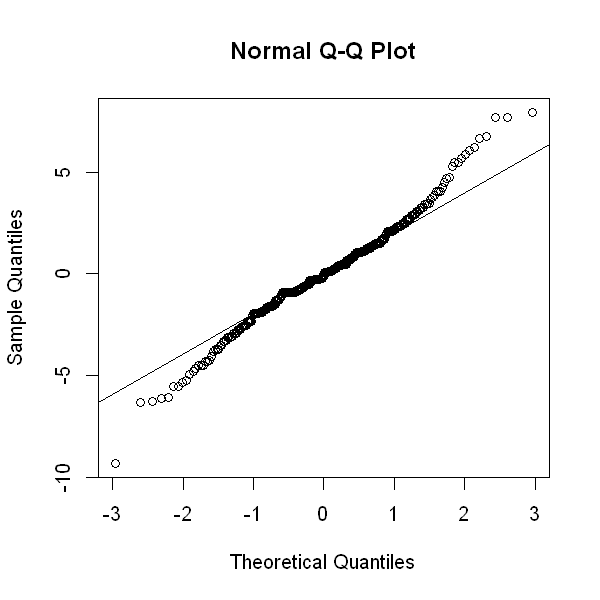


	Shapiro-Wilk normality test

data:  err.temp
W = 0.98284, p-value = 0.0005133

[1] "#############################################################"
[1] "Tuesday"


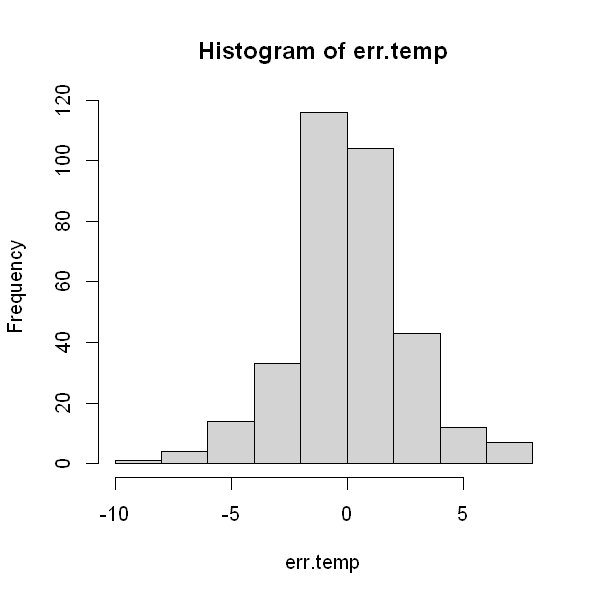

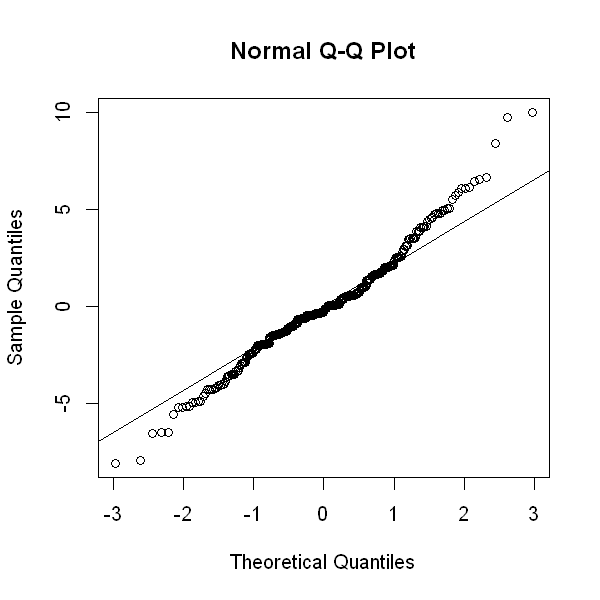


	Shapiro-Wilk normality test

data:  err.temp
W = 0.97944, p-value = 9.29e-05

[1] "#############################################################"
[1] "Wednesday"


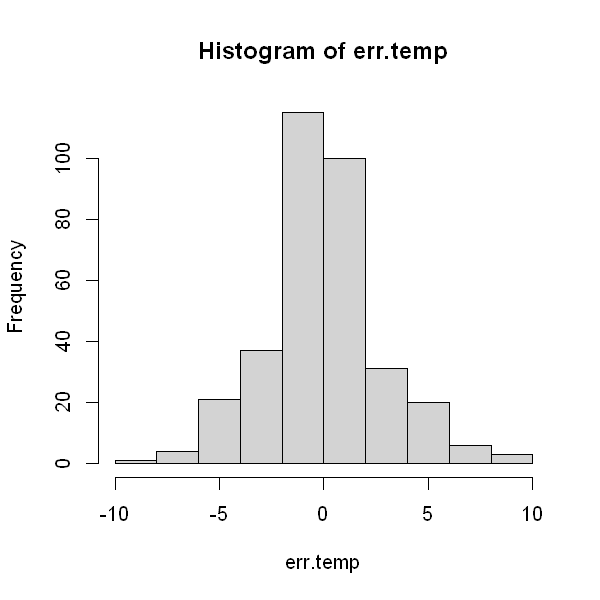

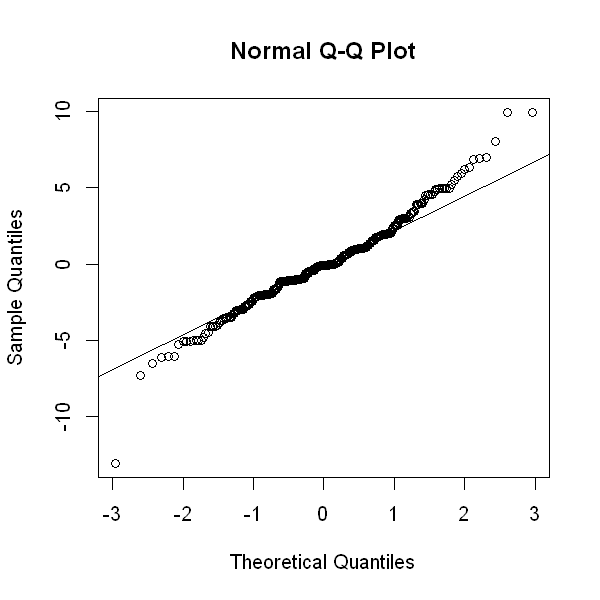


	Shapiro-Wilk normality test

data:  err.temp
W = 0.9744, p-value = 1.337e-05

[1] "#############################################################"
[1] "Thursday"


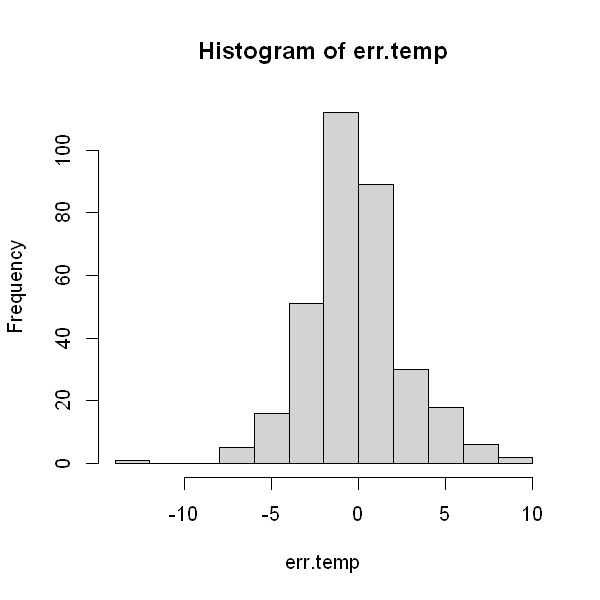

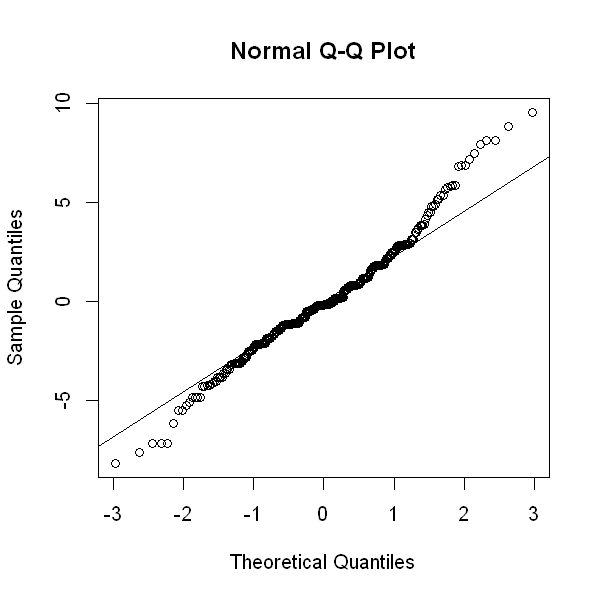


	Shapiro-Wilk normality test

data:  err.temp
W = 0.97742, p-value = 3.016e-05

[1] "#############################################################"
[1] "Friday"


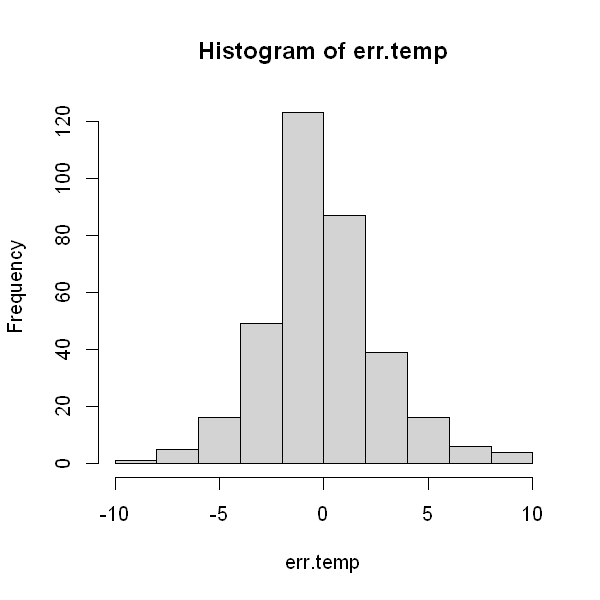

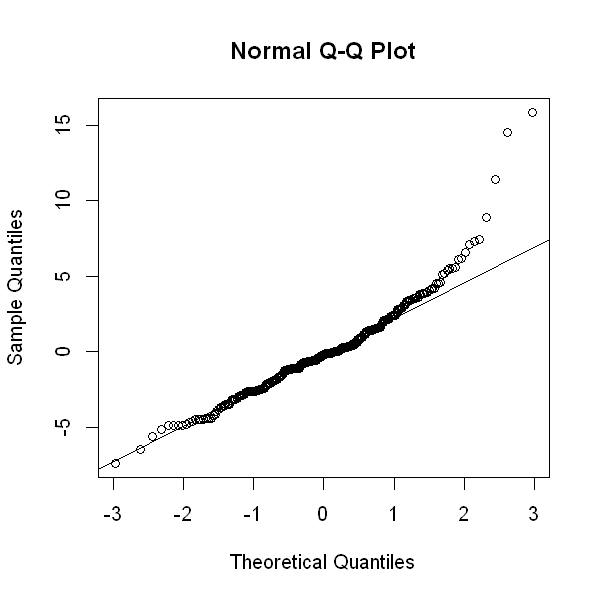


	Shapiro-Wilk normality test

data:  err.temp
W = 0.93223, p-value = 2.819e-11

[1] "#############################################################"
[1] "Saturday"


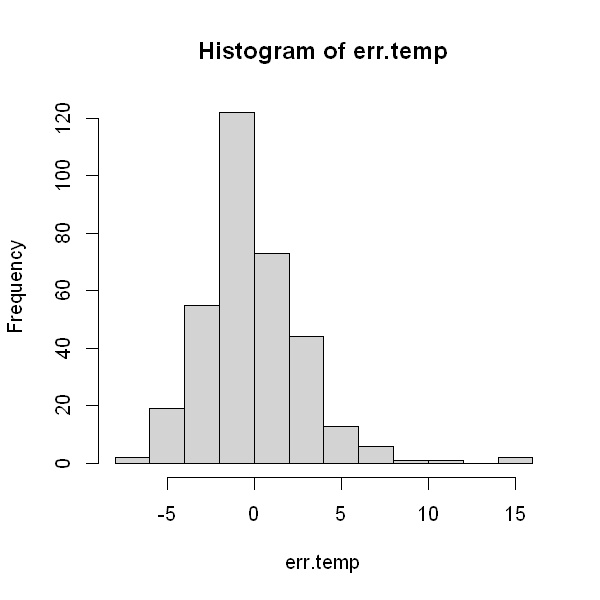

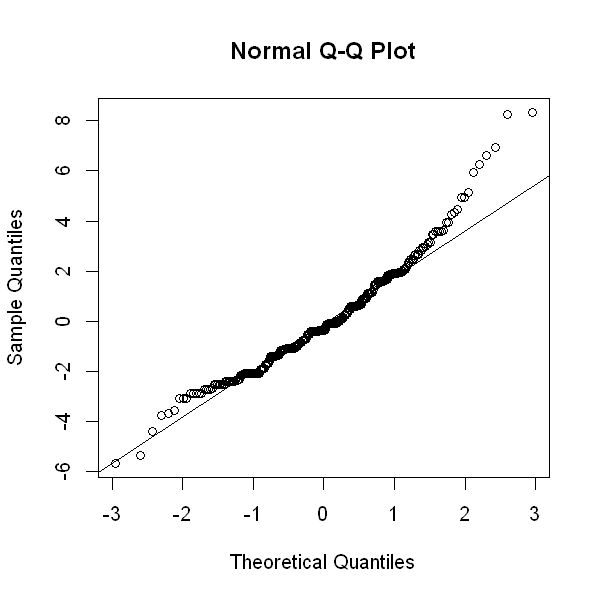


	Shapiro-Wilk normality test

data:  err.temp
W = 0.95929, p-value = 7.008e-08

[1] "#############################################################"
[1] "Sunday"


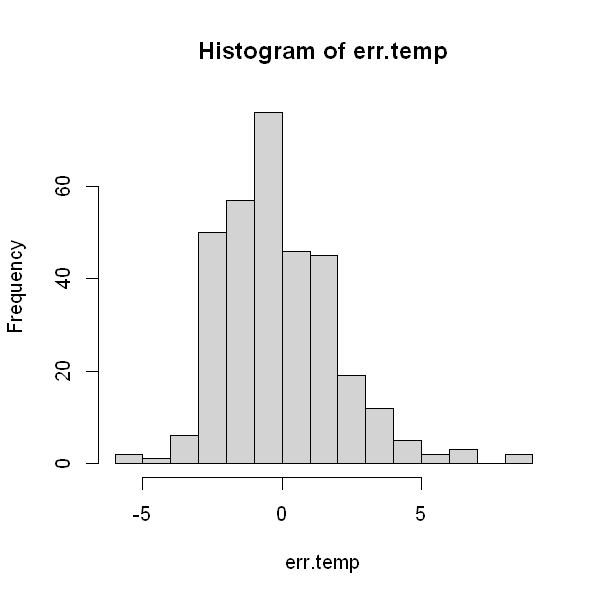

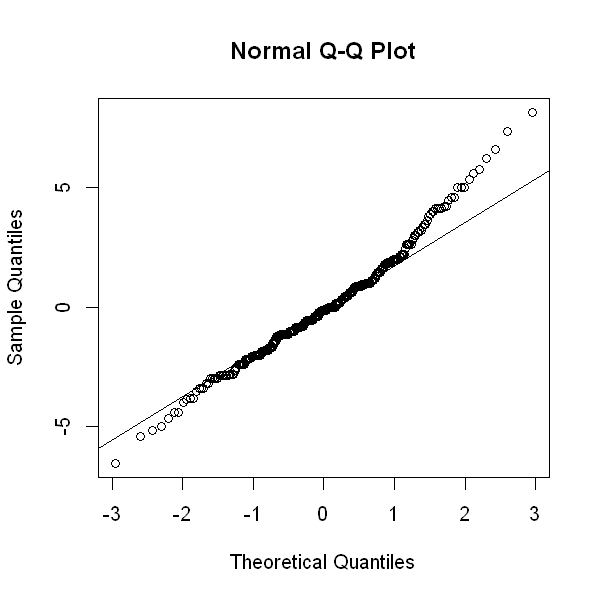


	Shapiro-Wilk normality test

data:  err.temp
W = 0.98162, p-value = 0.0003392

[1] "#############################################################"
[1] "Monday"

	Durbin-Watson test

data:  df_lm.mod[[i]]
DW = 2.1065, p-value = 0.8408
alternative hypothesis: true autocorrelation is greater than 0



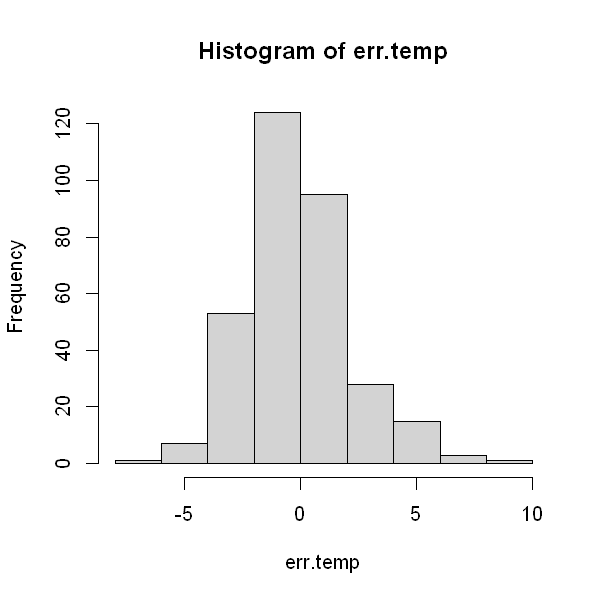

[1] "#############################################################"
[1] "Tuesday"

	Durbin-Watson test

data:  df_lm.mod[[i]]
DW = 1.761, p-value = 0.01877
alternative hypothesis: true autocorrelation is greater than 0



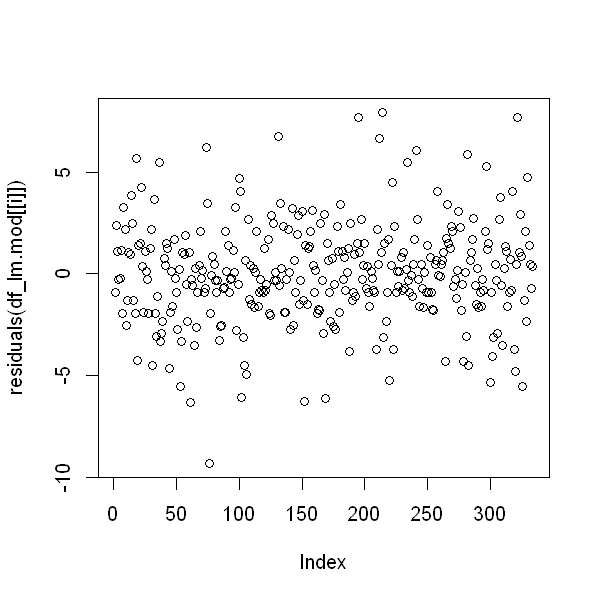

[1] "#############################################################"
[1] "Wednesday"

	Durbin-Watson test

data:  df_lm.mod[[i]]
DW = 1.6641, p-value = 0.001806
alternative hypothesis: true autocorrelation is greater than 0



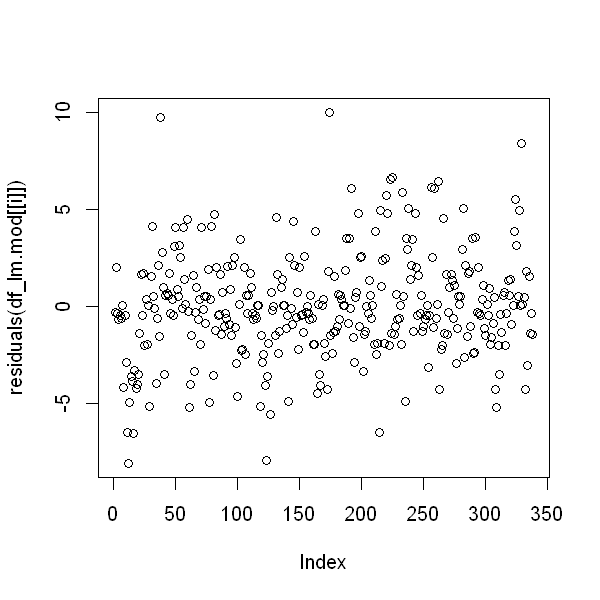

[1] "#############################################################"
[1] "Thursday"

	Durbin-Watson test

data:  df_lm.mod[[i]]
DW = 1.6284, p-value = 0.000482
alternative hypothesis: true autocorrelation is greater than 0



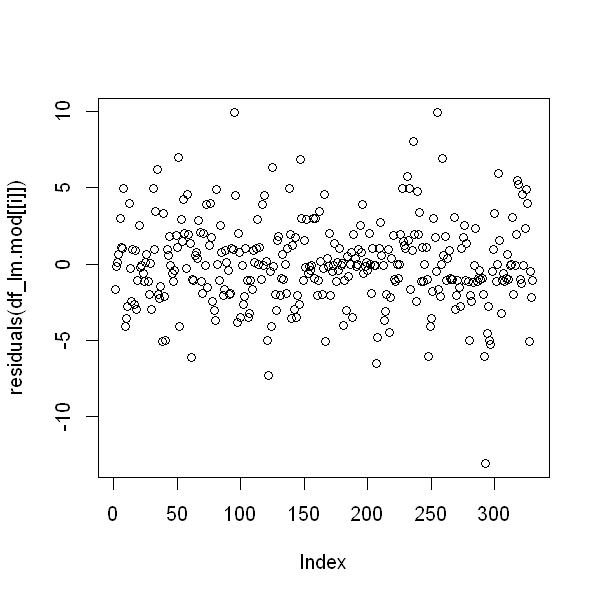

[1] "#############################################################"
[1] "Friday"

	Durbin-Watson test

data:  df_lm.mod[[i]]
DW = 1.5227, p-value = 1.293e-05
alternative hypothesis: true autocorrelation is greater than 0



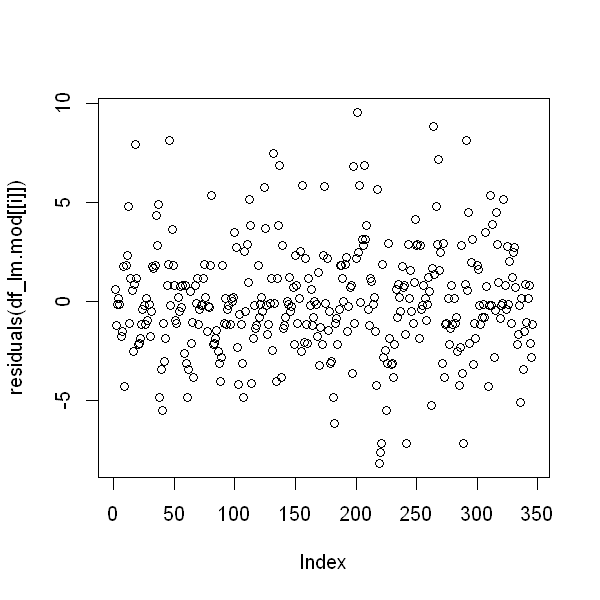

[1] "#############################################################"
[1] "Saturday"

	Durbin-Watson test

data:  df_lm.mod[[i]]
DW = 1.9324, p-value = 0.295
alternative hypothesis: true autocorrelation is greater than 0



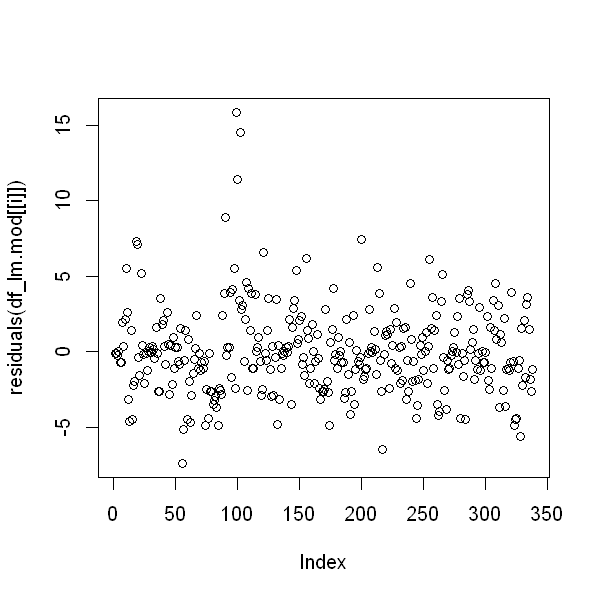

[1] "#############################################################"
[1] "Sunday"

	Durbin-Watson test

data:  df_lm.mod[[i]]
DW = 1.9171, p-value = 0.2503
alternative hypothesis: true autocorrelation is greater than 0



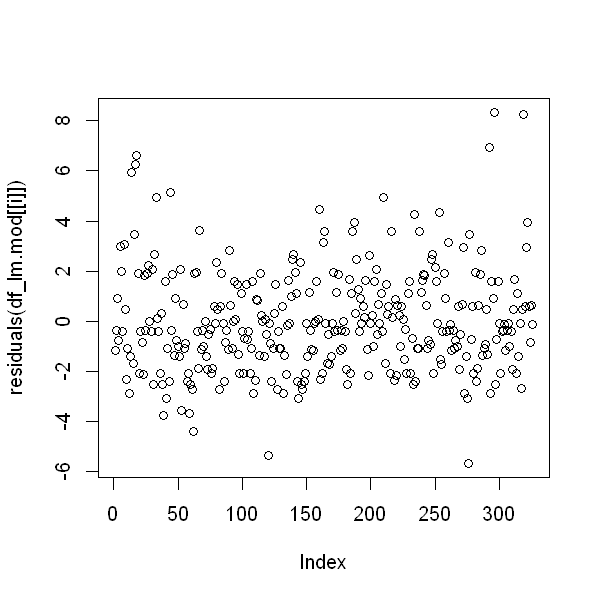

[1] "#############################################################"
[1] "Monday"

	studentized Breusch-Pagan test

data:  df_lm.mod[[i]]
BP = 54.983, df = 23, p-value = 0.000196

[1] "#############################################################"
[1] "Tuesday"

	studentized Breusch-Pagan test

data:  df_lm.mod[[i]]
BP = 56.07, df = 23, p-value = 0.0001384

[1] "#############################################################"
[1] "Wednesday"

	studentized Breusch-Pagan test

data:  df_lm.mod[[i]]
BP = 43.695, df = 23, p-value = 0.005722

[1] "#############################################################"
[1] "Thursday"

	studentized Breusch-Pagan test

data:  df_lm.mod[[i]]
BP = 49.813, df = 23, p-value = 0.0009747

[1] "#############################################################"
[1] "Friday"

	studentized Breusch-Pagan test

data:  df_lm.mod[[i]]
BP = 35.466, df = 23, p-value = 0.04673

[1] "#############################################################"
[1] "Saturday"

	studentized Br

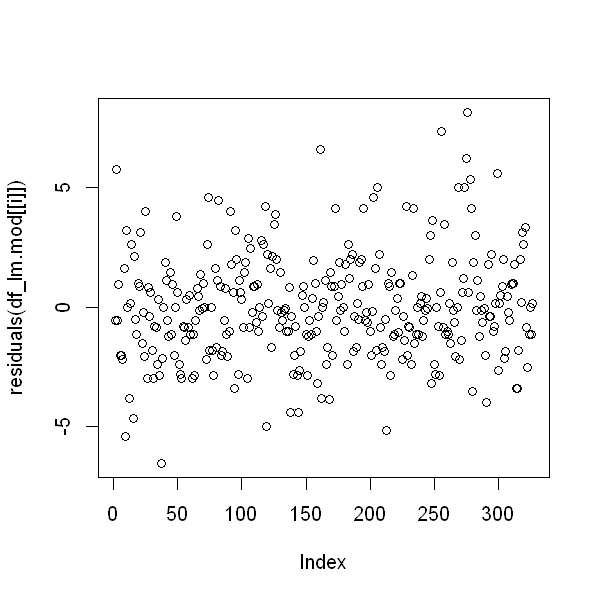

In [54]:
# Adjust Plot Size
options(repr.plot.width=5, repr.plot.height=5)

# Check Normallity Assumption
for (i in 1:length(df_lm.mod)) {
    err.temp <- residuals(df_lm.mod[[i]])
    print(names(df_lm.mod[i]))
    qqnorm(err.temp); qqline(err.temp)
    hist(err.temp)
    print(shapiro.test(err.temp))
    print('#############################################################')
}

# Check for indapendence of errors with Durbin Watson test and scatter plot
for (i in 1:length(df_lm.mod)) {
    print(names(df_lm.mod[i]))
    print(dwtest(df_lm.mod[[i]]))
    plot(residuals(df_lm.mod[[i]]))
    print('#############################################################')
}

# Check constant variance assumption using a Breusch-Pagan Test
for (i in 1:length(df_lm.mod)) {
    print(names(df_lm.mod[i]))
    print(bptest(df_lm.mod[[i]]))
    print('#############################################################')
}


### 4.3.2. Forecast and Testing (Multiple Linear Regression)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,7.355556,26.28857,18.46667,4.518245,11.90302,0.2355266,0.6715555


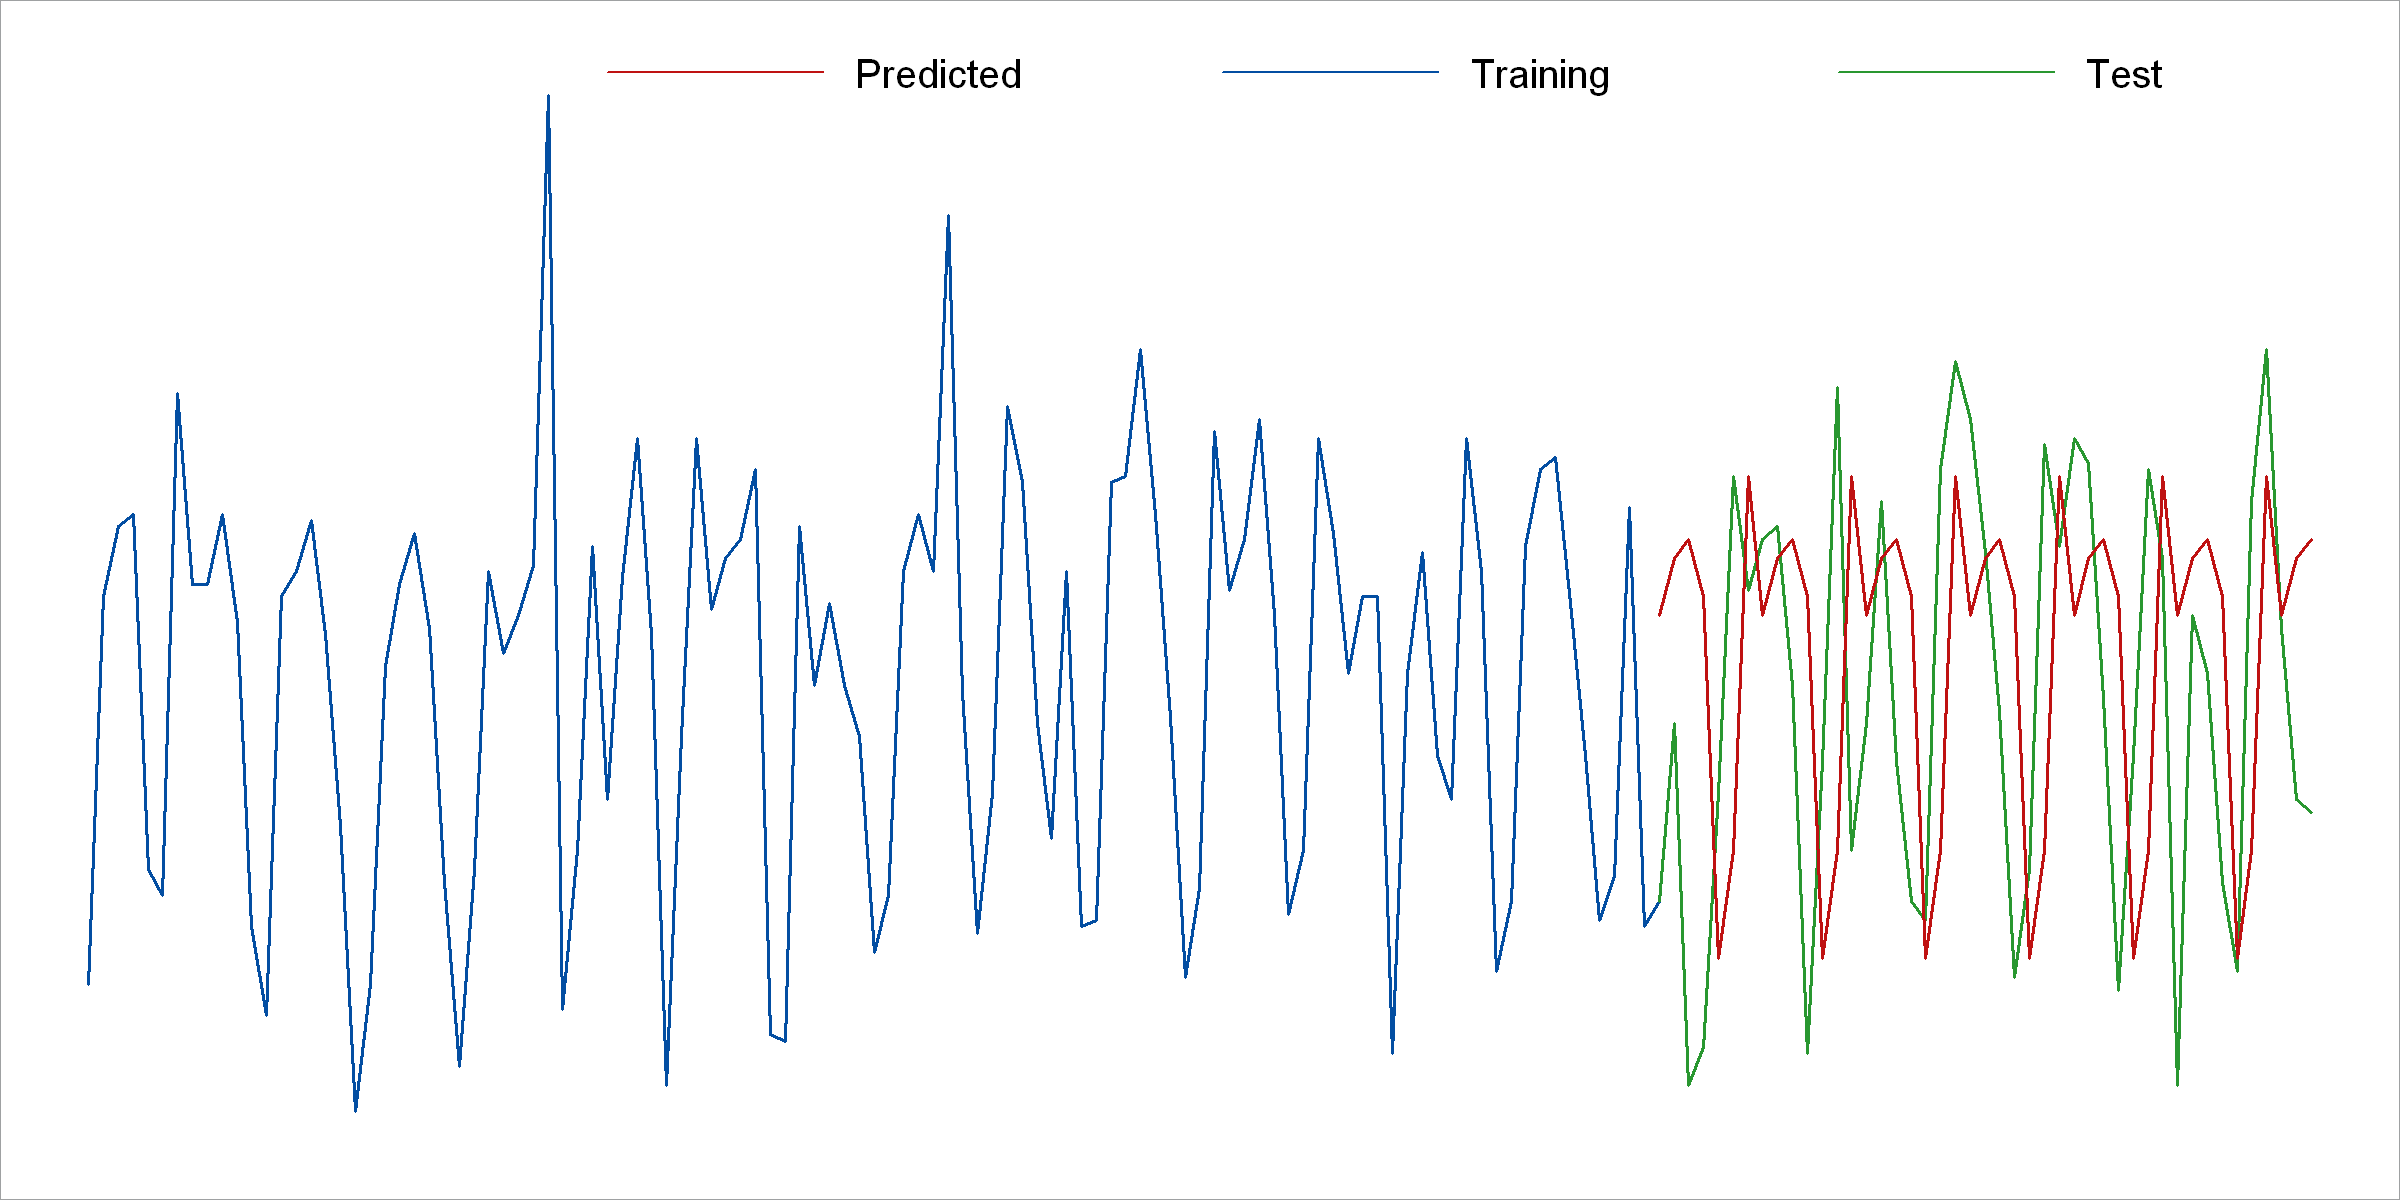

In [65]:
# Adjust Plot Size
options(repr.plot.width=20, repr.plot.height=10)

# Create Time Series From results dataframe
act <- ts(df_lm$ActualCalls,start=c(2019,107), end=c(2019,151), frequency =7)
pre <- ts(df_lm$PredictedCalls,start=c(2019,107), end=c(2019,151), frequency =7)

# View Accuracy Statistics
accuracy(act, pre)

# Plot Results
png(filename="LMmodel.png", width = 450, height = 100)
par(
    cex.lab=1, cex.axis=1, cex.main=1, mar=c(0,0,0,0), 
    mgp=c(0,0,0), family="sans"
)
plot(
    all_ts, col='#034EA2', lwd=3, xaxt='n',
     ylab='Calls Per Day', main='', ylim=c(75,250), 
    xlab='', fg='#9fa1a2'
)
title(line=0)
lines(test_ts, col='#299730', lwd=3)
lines(pre, col='#BF1212', lwd=3)
legend( 
    "topright", c("Predicted", "Training", "Test"), 
    col=c('#BF1212','#034EA2','#299730'), pt.cex=, cex=2, 
    lty=1, lwd=2, xjust = 1, text.width=2.5, bty='n', seg.len=2,
    x.intersp=0.3, ncol=3
) 
dev.off()

## 4.4. ARIMA

In [71]:
# Create Optimal Arima as per training data
arima_mod <- auto.arima(train_ts, seasonal=TRUE)
arima_mod

Series: train_ts 
ARIMA(0,0,1)(2,1,0)[7] 

Coefficients:
         ma1     sar1     sar2
      0.1866  -0.7566  -0.3423
s.e.  0.1095   0.1019   0.1006

sigma^2 estimated as 545.5:  log likelihood=-453.11
AIC=914.23   AICc=914.65   BIC=924.61

### 4.4.1. Testing the Residuals (ARIMA)


	Box-Pierce test

data:  arima_err
X-squared = 5.9971, df = 6, p-value = 0.4235



	Box-Ljung test

data:  arima_err
X-squared = 6.6746, df = 7, p-value = 0.4635


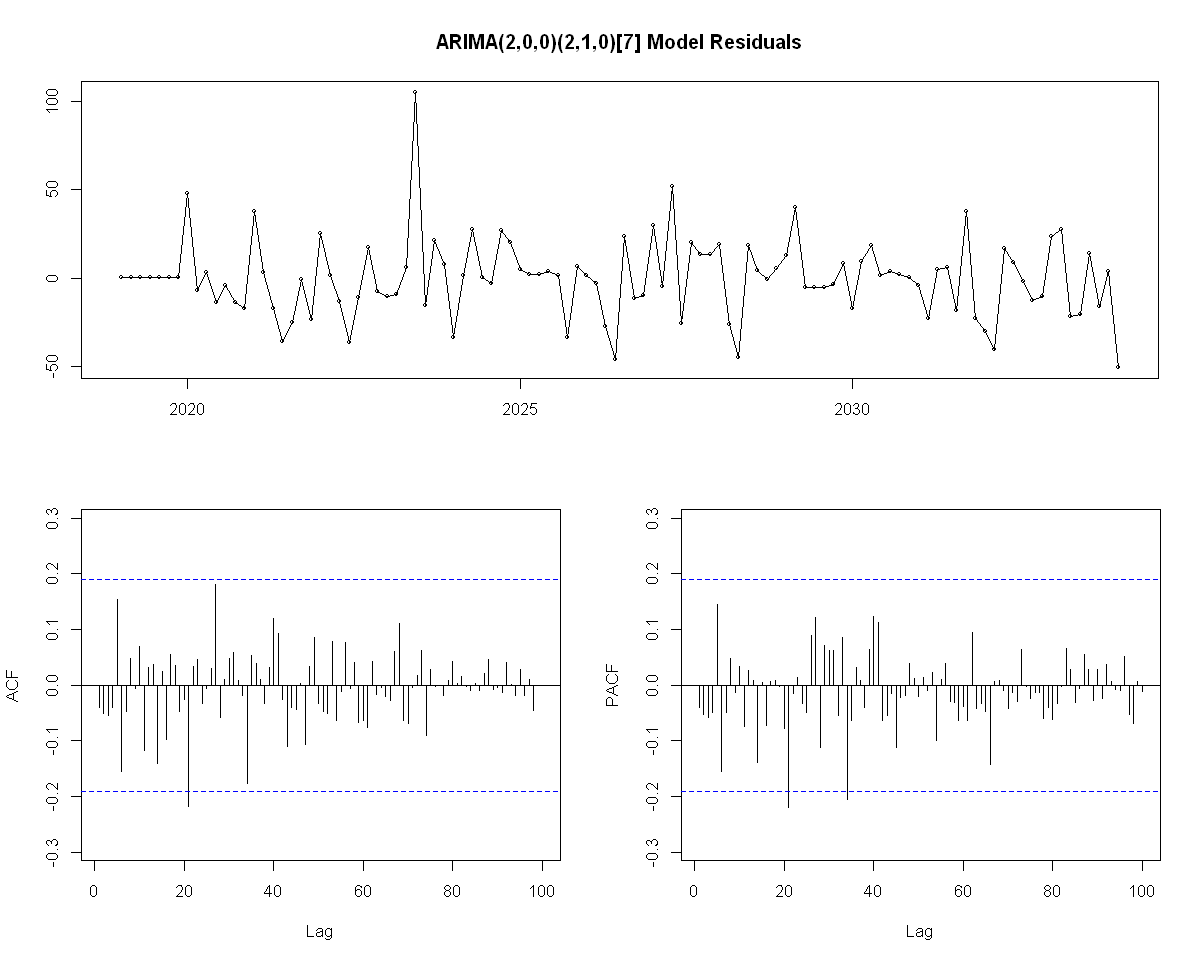

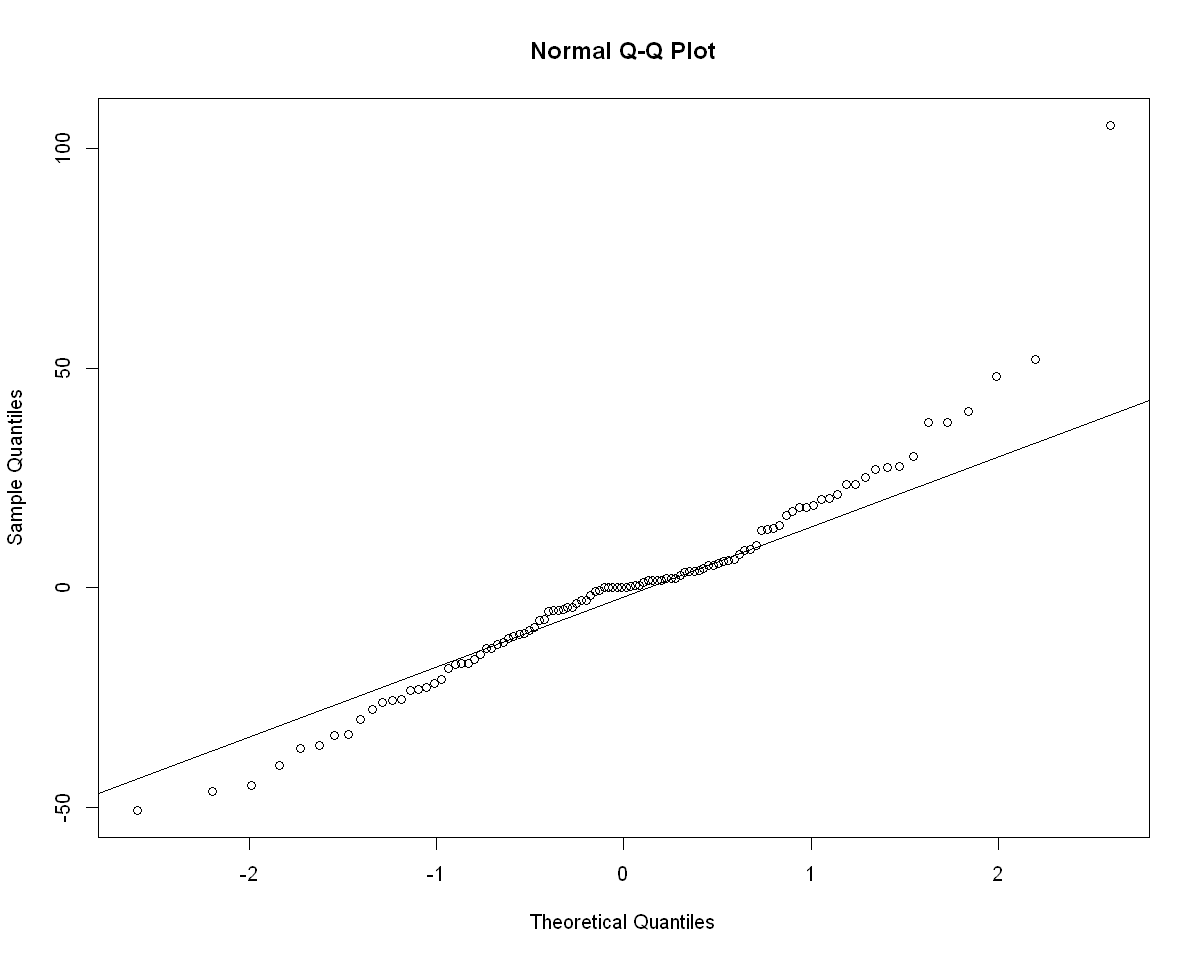

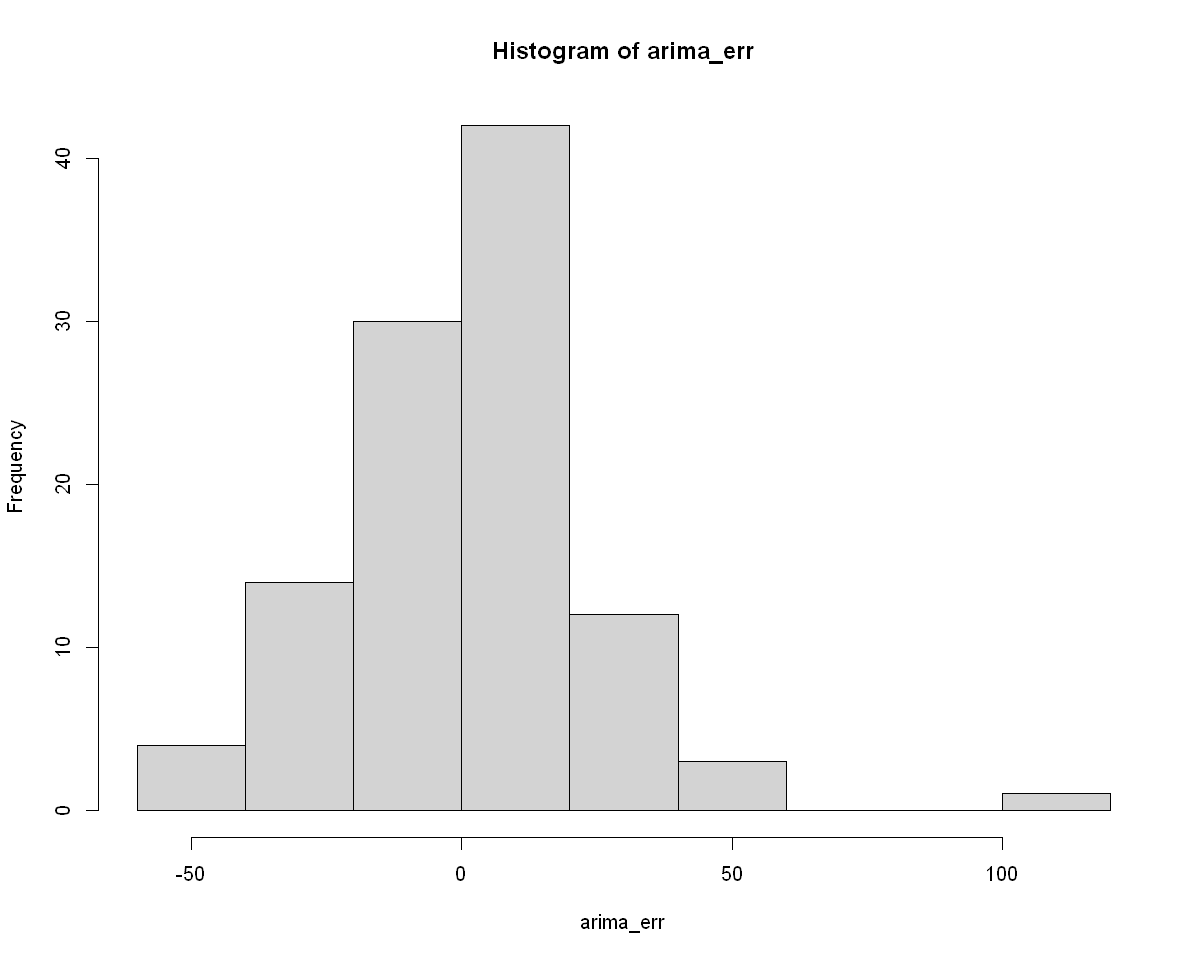

In [83]:
# Get Error Values
arima_err <- residuals(arima_mod)

#  Plotting the ACF nd PACF
options(repr.plot.width=10, repr.plot.height=8)
tsdisplay(arima_err, lag.max=100, main='ARIMA(2,0,0)(2,1,0)[7] Model Residuals')

# Statistical Tests for autocorrelation
Box.test(arima_err, lag=6) # Change Lag value to test the relevant lags
Box.test(arima_err, type="Ljung-Box", lag=7)

# Testing for Normality in the residuals
qqnorm(arima_err); qqline(arima_err)
hist(arima_err)

### 4.4.2. Forecast and Testing (ARIMA)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.2451239,22.22688,15.65824,-1.650123,10.75949,0.7643816,-0.04024972,NA
Test set,0.3621460,26.00175,18.79981,-3.144149,14.01473,0.9177422,0.26871894,0.5280393


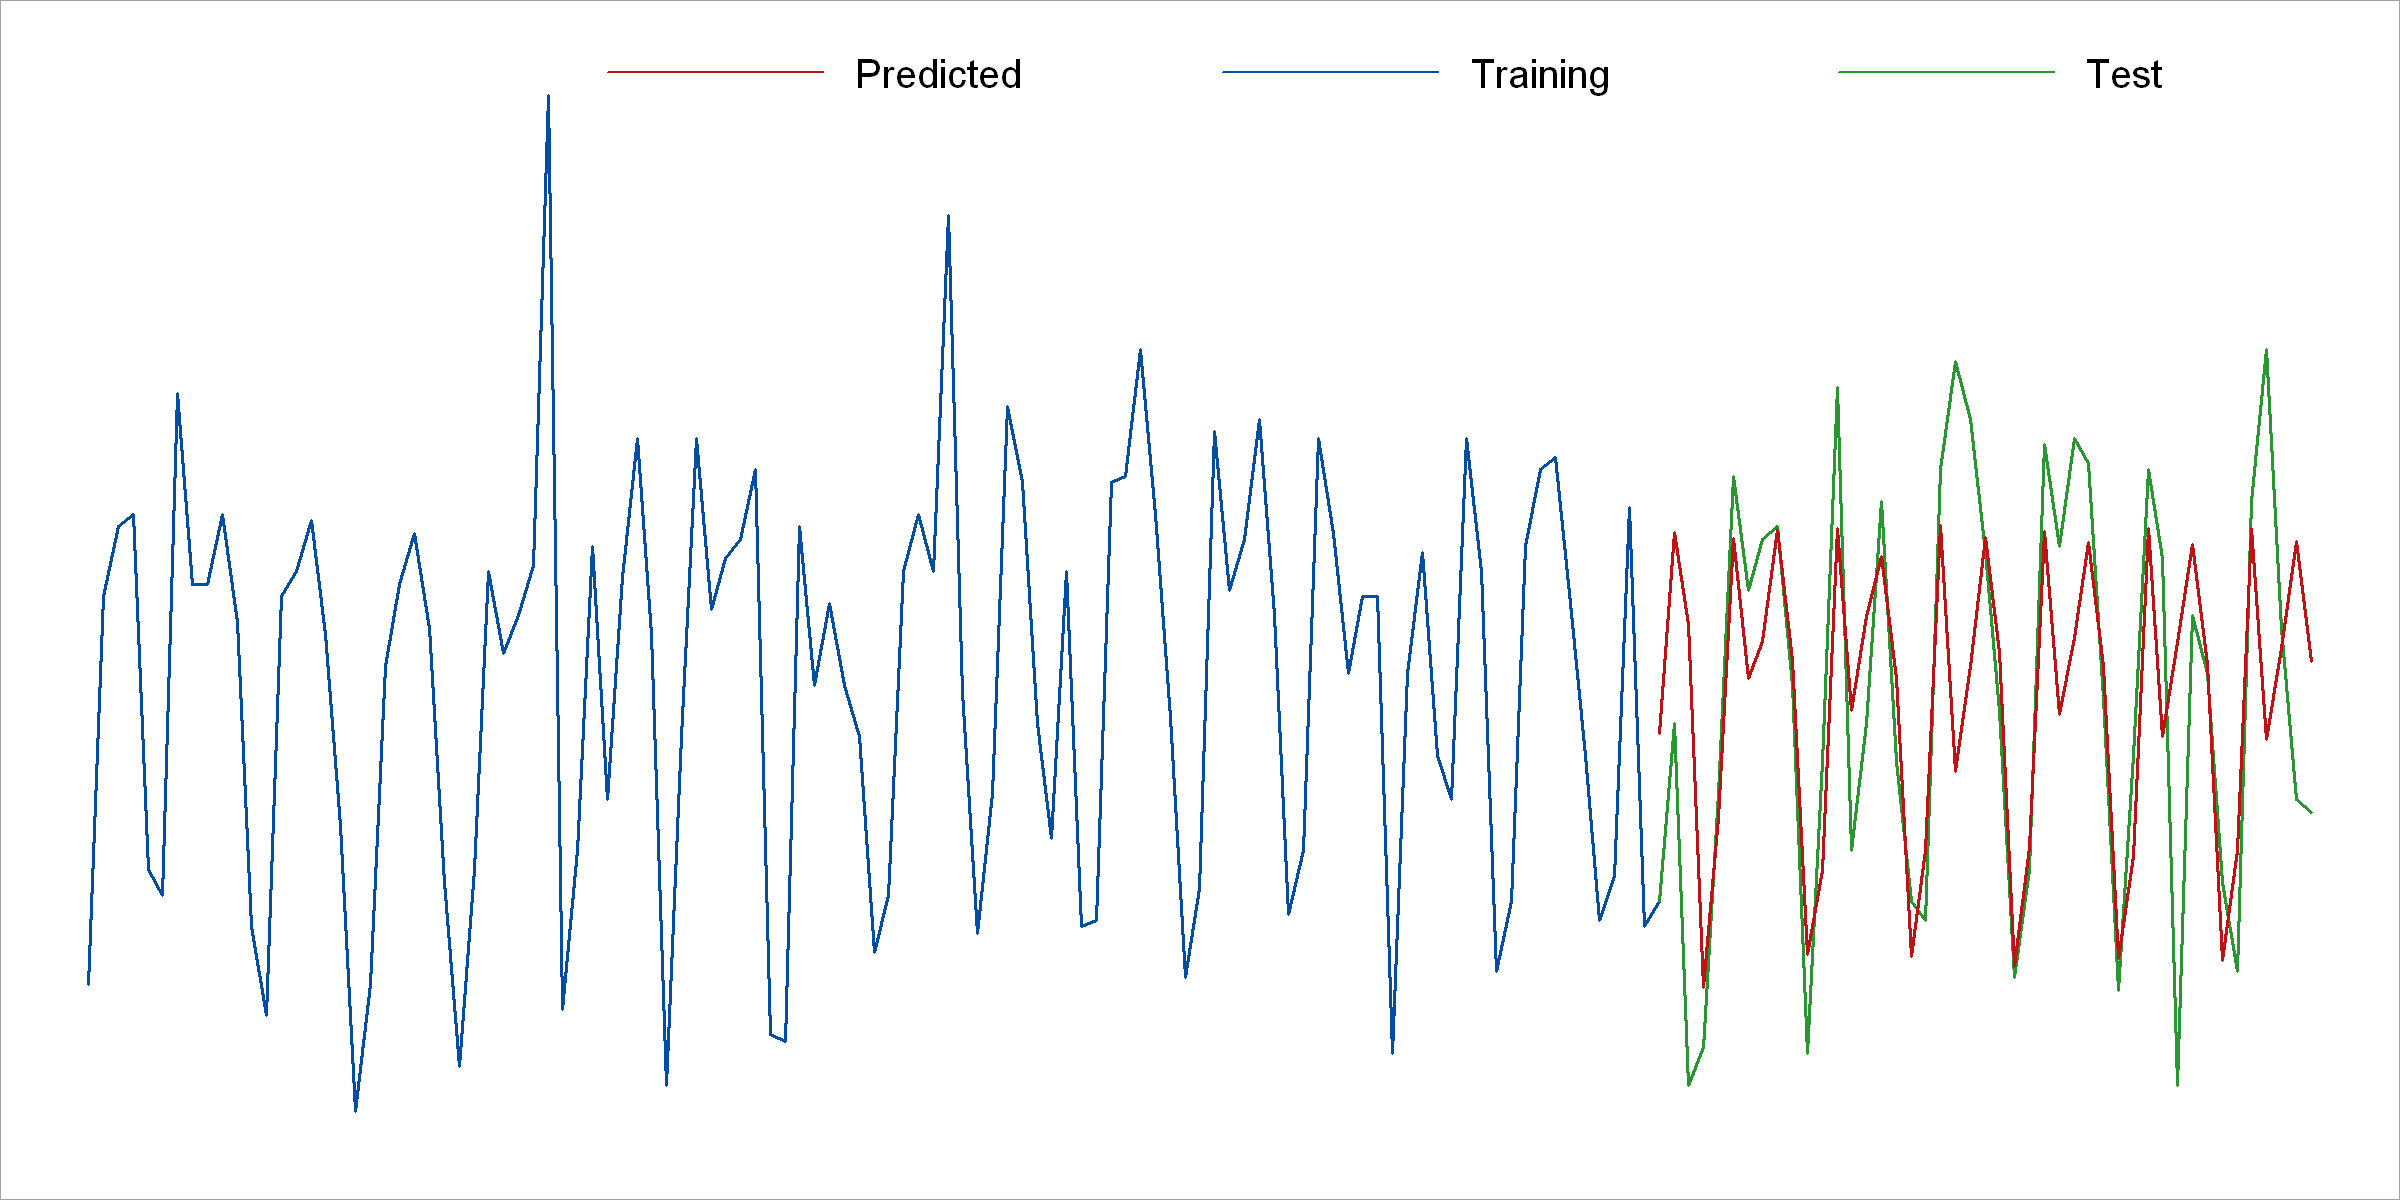

In [80]:
# Adjust  the Plot Size
options(repr.plot.width=20, repr.plot.height=10)

# Create Forecast
arima_fcast <- forecast(train_ts, h=length(test_ts), level=90, model=arima_mod)

# View Accuracy Statistics
testAcc <- accuracy(arima_fcast, x=test_ts) 
testAcc

# Plot The Results
png(filename="ARIMAmodel.png", width = 450, height = 100)
par(
    cex.lab=1, cex.axis=1, cex.main=1, mar=c(0,0,0,0), 
    mgp=c(0,0,0), family="sans"
)
plot(
    all_ts, col ='#034EA2', lwd=3, xaxt='n',ylab='Calls Per Day',
    main='', ylim=c(75,250), xlab='', fg='#9fa1a2'
)
lines(test_ts, col= '#299730', lwd=3)
lines(arima_fcast$mean, col = '#BF1212', lwd=3)
title(line= -1)
legend( 
    "topright", c("Predicted","Training", "Test"), 
    col=c('#BF1212','#034EA2','#299730'), pt.cex=, cex=2, lty=1, lwd=2, 
    xjust = 0.5, text.width=2.5, bty='n', seg.len=2, x.intersp=0.3, ncol=3
) 
dev.off()



# 5. Summary and Conclusions
Given the results an ARIMA model was selected. Thus, all the data was used to make the final prediction. A prediction timeframe of two weeks was selected.

         Point Forecast     Lo 90    Hi 90
2040.571       99.72399  64.61432 134.8337
2040.714      124.99003  88.82710 161.1530
2040.857      181.65663 145.49386 217.8194
2041.000      160.58629 124.42614 196.7464
2041.143      154.72909 118.56894 190.8892
2041.286      171.46444 135.30428 207.6246
2041.429      147.43518 111.27503 183.5953
2041.571      104.48975  68.31477 140.6647
2041.714      121.51548  85.33960 157.6914
2041.857      181.05134 144.87557 217.2271
2042.000      167.44164 131.26769 203.6156
2042.143      155.27054 119.09659 191.4445
2042.286      164.76623 128.59228 200.9402
2042.429      144.38355 108.20960 180.5575

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-0.2451239,22.22688,15.65824,-1.650123,10.75949,0.7643816,-0.04024972


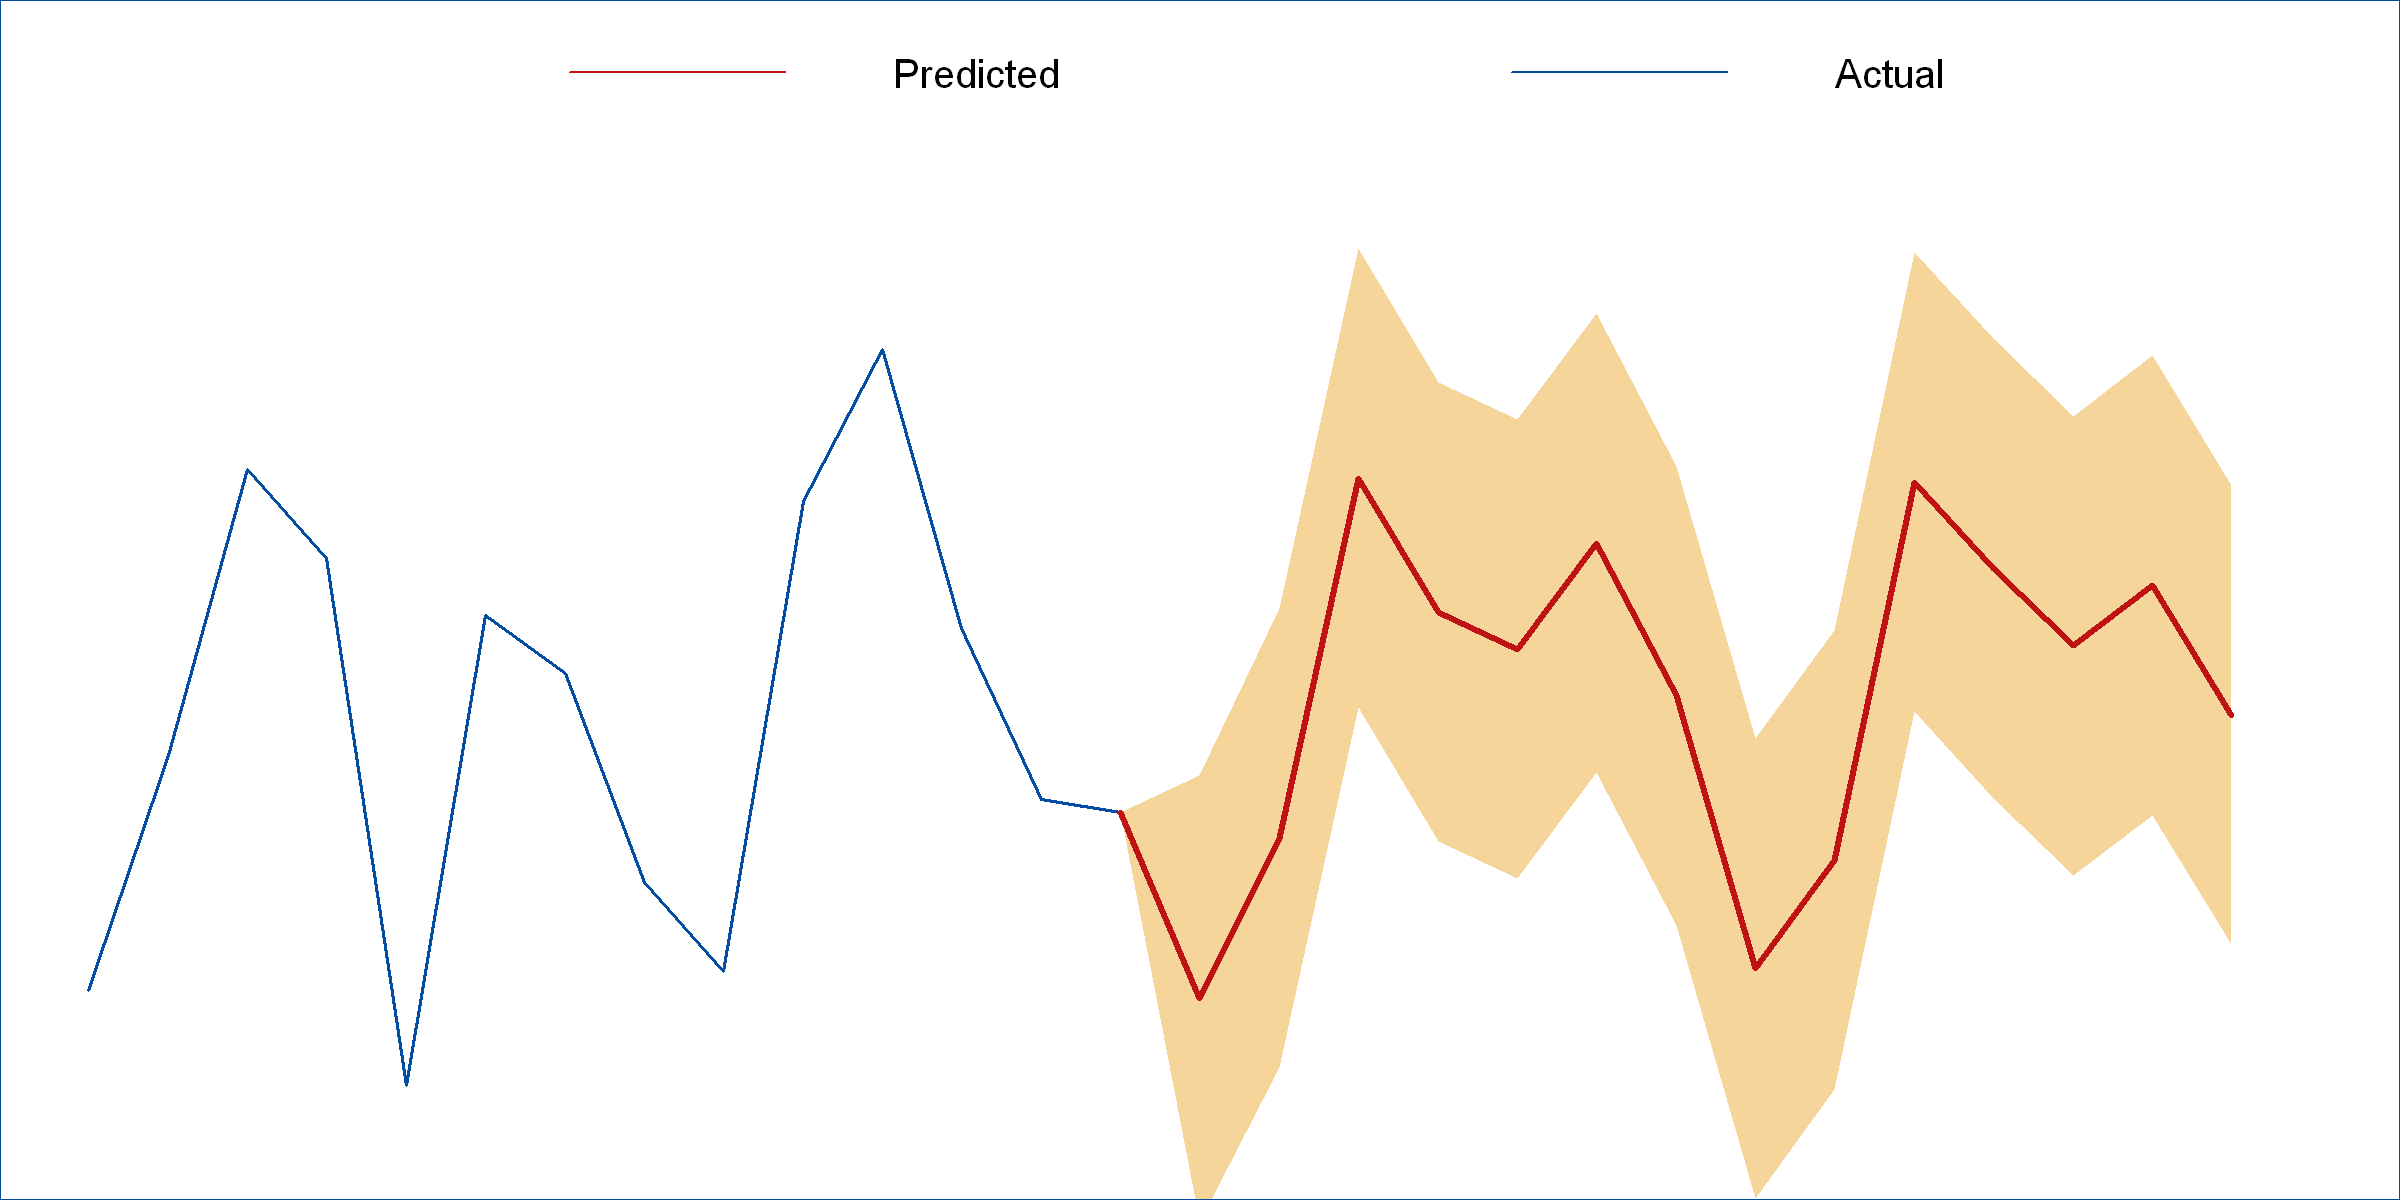

In [81]:
# Adjust Plot Size
options(repr.plot.width=20, repr.plot.height=10)

# Generate ARIMA from All the Data for Forecasting
arima_mod.final <- auto.arima(all_ts, seasonal=TRUE)

# Create a two week forecast with 90% confidence
arima.7day <- forecast(all_ts, h=14, level=90, model=arima_mod.final)
arima.7day

# View Accuracy Statistics
testAcc <- accuracy(arima_fcast) 
testAcc

# Plot The Results
png(filename="Finalmodel.png", width = 502, height = 110)
par(
    cex.lab=1, cex.axis=1, cex.main=1, mar=c(0,0,0,0),
    mgp=c(0,0,0), family="sans"
)
plot(arima.7day, col ='#034EA2', lwd=3, xaxt='n',ylab='Calls Per Day',
     shadecols= '#f6d59b', main='', ylim=c(75,250), xlab='', 
     fg='#034EA2',fcol='#BF1212', include=14, showgap=FALSE, flwd=5
)
legend( "topright", c("Predicted", "Actual"), col=c('#BF1212','#034EA2'), 
       pt.cex=, cex=2, lty=1, lwd=2, xjust = 1, bty='n', seg.len=2, ncol=2) 
dev.off()

## 5.1. Testing The Residuals (Forecast Model)
Testing the residuals of the final ARIMA model.


	Box-Pierce test

data:  arima_err
X-squared = 5.7431, df = 8, p-value = 0.676



	Box-Ljung test

data:  arima_err
X-squared = 5.1952, df = 7, p-value = 0.6362


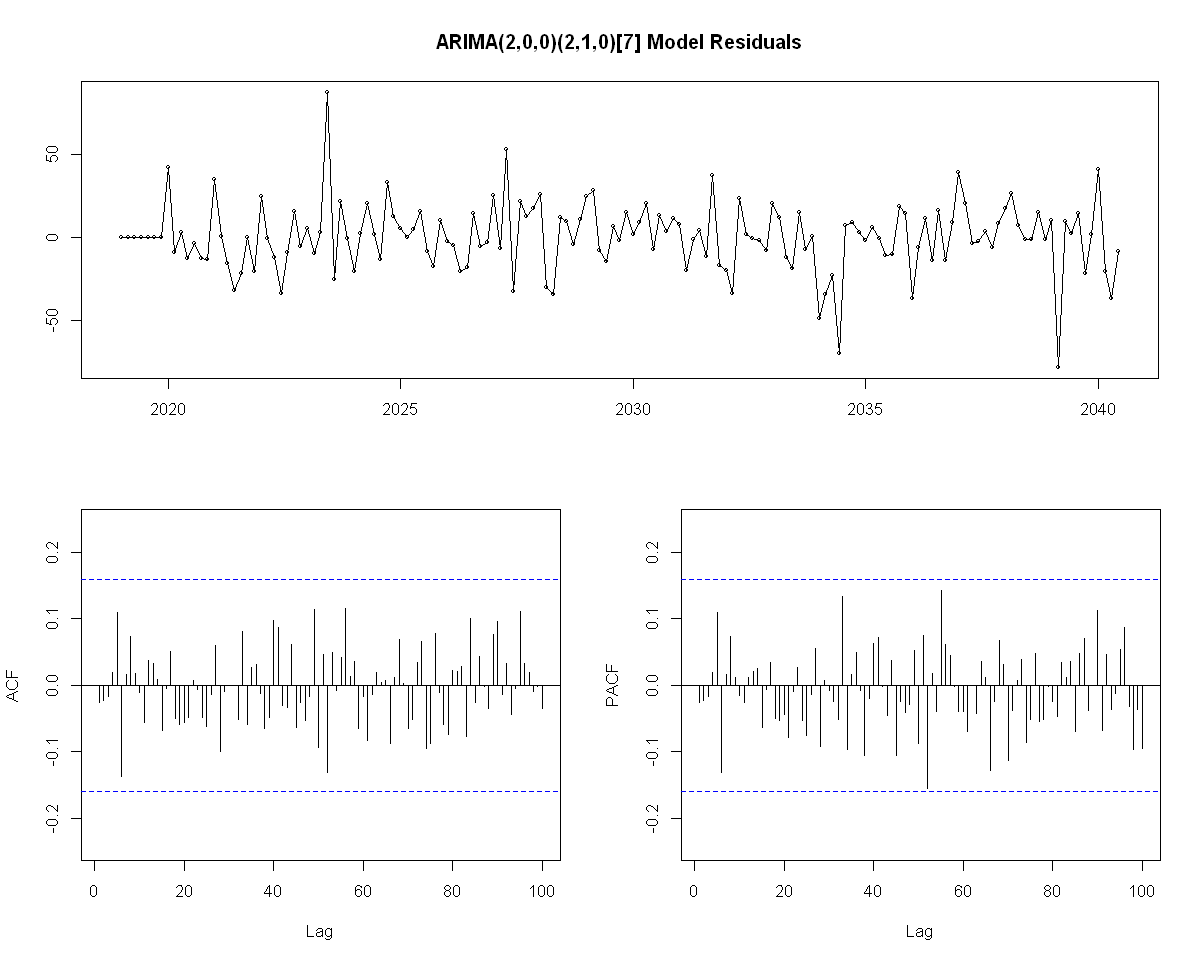

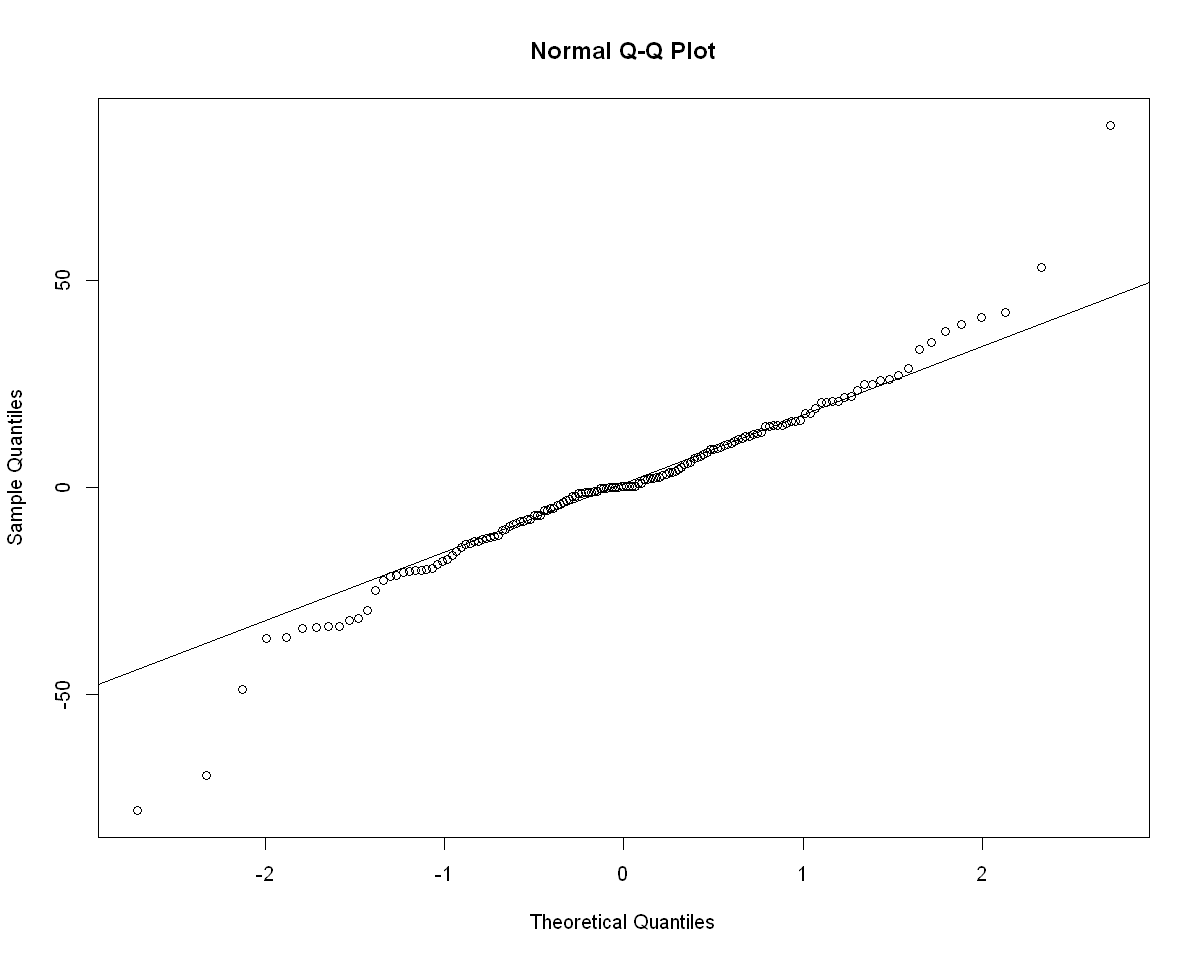


	Shapiro-Wilk normality test

data:  arima_err
W = 0.95724, p-value = 0.0001302


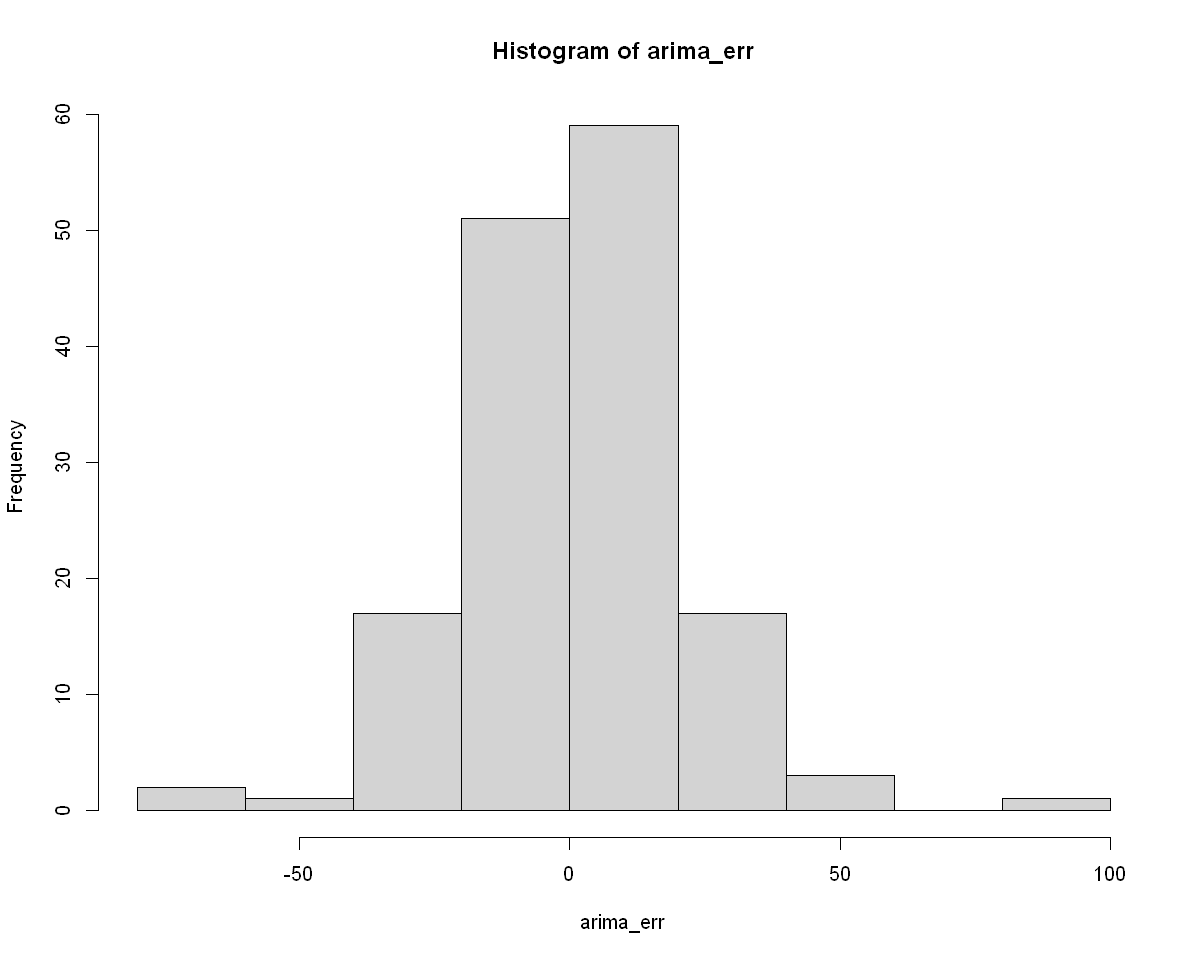

In [82]:
# Adjust the Pllot Size
options(repr.plot.width=10, repr.plot.height=8)

# Get Error Values
arima_err <- residuals(arima_mod.final)

#  Plotting the ACF nd PACF
tsdisplay(arima_err, lag.max=100, main='ARIMA(2,0,0)(2,1,0)[7] Model Residuals')

# Statistical Tests for autocorrelation
Box.test(arima_err, lag=8) # Change Lag value to test the relevant lags
Box.test(arima_err, type="Ljung-Box", lag=7)

# Testing for Normality in the residuals
qqnorm(arima_err); qqline(arima_err)
hist(arima_err)
shapiro.test(arima_err)